In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/talib-binary/talib_binary-0.4.19-cp37-cp37m-manylinux1_x86_64.whl
/kaggle/input/btcinusd/BTC-2019min.csv
/kaggle/input/btcinusd/BTC-Hourly.csv
/kaggle/input/btcinusd/BTC-Daily.csv
/kaggle/input/btcinusd/BTC-2020min.csv
/kaggle/input/btcinusd/BTC-2017min.csv
/kaggle/input/btcinusd/BTC-2018min.csv
/kaggle/input/btcinusd/BTC-2021min.csv


In [2]:
# Import plotly and tallib
!pip install plotly
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 114840 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 9.2 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.28-cp310-cp310-linux_x86_64.whl size=454302 sha256=e7d866eff9b713144e9687d1a780f6736527bf5c62f9a1db3196878167b28235
  Stored in directory: /root/.cache/pip/wheels/66/54/9d/

The purpose of this python module is to predict the price movements of the bitcoin cryptocurrency asset using a recurrent convolutional neural network consisting of convolutional and lstm layers.

Created on Sun 19/11/2023

@author: Kaylen Smith Darnbrook, InquisitorNova

In [3]:
# Import the relevant modules

# Handles the mathematical operations
import numpy as np
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import pearsonr

# Handles the vector operations on the data
import pandas as pd
import talib as ta
import shap

# Handles the plotting and analysis of the data:
import seaborn as sns; sns.set_theme(style = "whitegrid")
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import mutual_info_regression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rc("font", family = "Times New Roman")
plt.style.use("seaborn")

# Import Machine Learning modules
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [4]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [5]:
# Reset the size of the matplotlib and seaborn plots
from matplotlib.pyplot import rcParams
rcParams["figure.figsize"] = (20,20)

In [6]:
# Import the hourly dataset
btcdf_hourly = pd.read_csv("/kaggle/input/btcinusd/BTC-Hourly.csv")
btcdf_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33259 entries, 0 to 33258
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        33259 non-null  int64  
 1   date        33259 non-null  object 
 2   symbol      33259 non-null  object 
 3   open        33259 non-null  float64
 4   high        33259 non-null  float64
 5   low         33259 non-null  float64
 6   close       33259 non-null  float64
 7   Volume BTC  33259 non-null  float64
 8   Volume USD  33259 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.3+ MB


In [7]:
# Displays the first 10 examples
btcdf_hourly.head(10)

unix                 date   symbol      open      high       low  \
0  1646092800  2022-03-01 00:00:00  BTC/USD  43221.71  43626.49  43185.48   
1  1646089200  2022-02-28 23:00:00  BTC/USD  43085.30  43364.81  42892.37   
2  1646085600  2022-02-28 22:00:00  BTC/USD  41657.23  44256.08  41650.29   
3  1646082000  2022-02-28 21:00:00  BTC/USD  41917.09  41917.09  41542.60   
4  1646078400  2022-02-28 20:00:00  BTC/USD  41361.99  41971.00  41284.11   
5  1646074800  2022-02-28 19:00:00  BTC/USD  41228.49  41406.03  41036.37   
6  1646071200  2022-02-28 18:00:00  BTC/USD  41432.91  41476.20  41032.06   
7  1646067600  2022-02-28 17:00:00  BTC/USD  41031.78  41432.91  40524.73   
8  1646064000  2022-02-28 16:00:00  BTC/USD  40860.33  41341.18  40710.00   
9  1646060400  2022-02-28 15:00:00  BTC/USD  39830.50  40912.56  39634.59   

      close  Volume BTC    Volume USD  
0  43312.27   52.056320  2.254677e+06  
1  43178.98  106.816103  4.612210e+06  
2  42907.32  527.540571  2.263535e+07  
3  41659.53   69.751680  2.905822e+06  
4  41914.97  247.151654  1.035935e+07  
5  41362.52  114.268970  4.726453e+06  
6  41233.87   71.233382  2.937228e+06  
7  41432.91  192.789480  7.987829e+06  
8  41008.37  291.623181  1.195899e+07  
9  40846.38  365.055972  1.491121e+07

In [8]:
# Displays the summary statistics
btcdf_hourly.describe()

unix          open          high           low         close  \
count  3.325900e+04  33259.000000  33259.000000  33259.000000  33259.000000   
mean   1.586228e+09  20119.546772  20232.957473  19997.069777  20120.684800   
std    3.456429e+07  18537.219607  18646.950933  18418.320297  18537.695044   
min    1.526364e+09   3139.760000   3158.340000   3122.280000   3139.760000   
25%    1.556296e+09   7022.865000   7055.835000   6970.570000   7022.865000   
50%    1.586228e+09   9700.040000   9740.270000   9657.000000   9700.320000   
75%    1.616161e+09  36415.305000  36735.380000  36104.235000  36423.040000   
max    1.646093e+09  68635.050000  69000.000000  68447.000000  68627.010000   

         Volume BTC    Volume USD  
count  3.325900e+04  3.325900e+04  
mean   1.612380e+06  2.965701e+06  
std    3.102328e+06  7.329787e+06  
min    0.000000e+00  0.000000e+00  
25%    1.903241e+02  1.682800e+02  
50%    6.093271e+05  5.248300e+02  
75%    1.929240e+06  3.120014e+06  
max    6.857061e+07  2.582324e+08

array([[<Axes: title={'center': 'unix'}>,
        <Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'high'}>],
       [<Axes: title={'center': 'low'}>,
        <Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'Volume BTC'}>],
       [<Axes: title={'center': 'Volume USD'}>, <Axes: >, <Axes: >]],
      dtype=object)

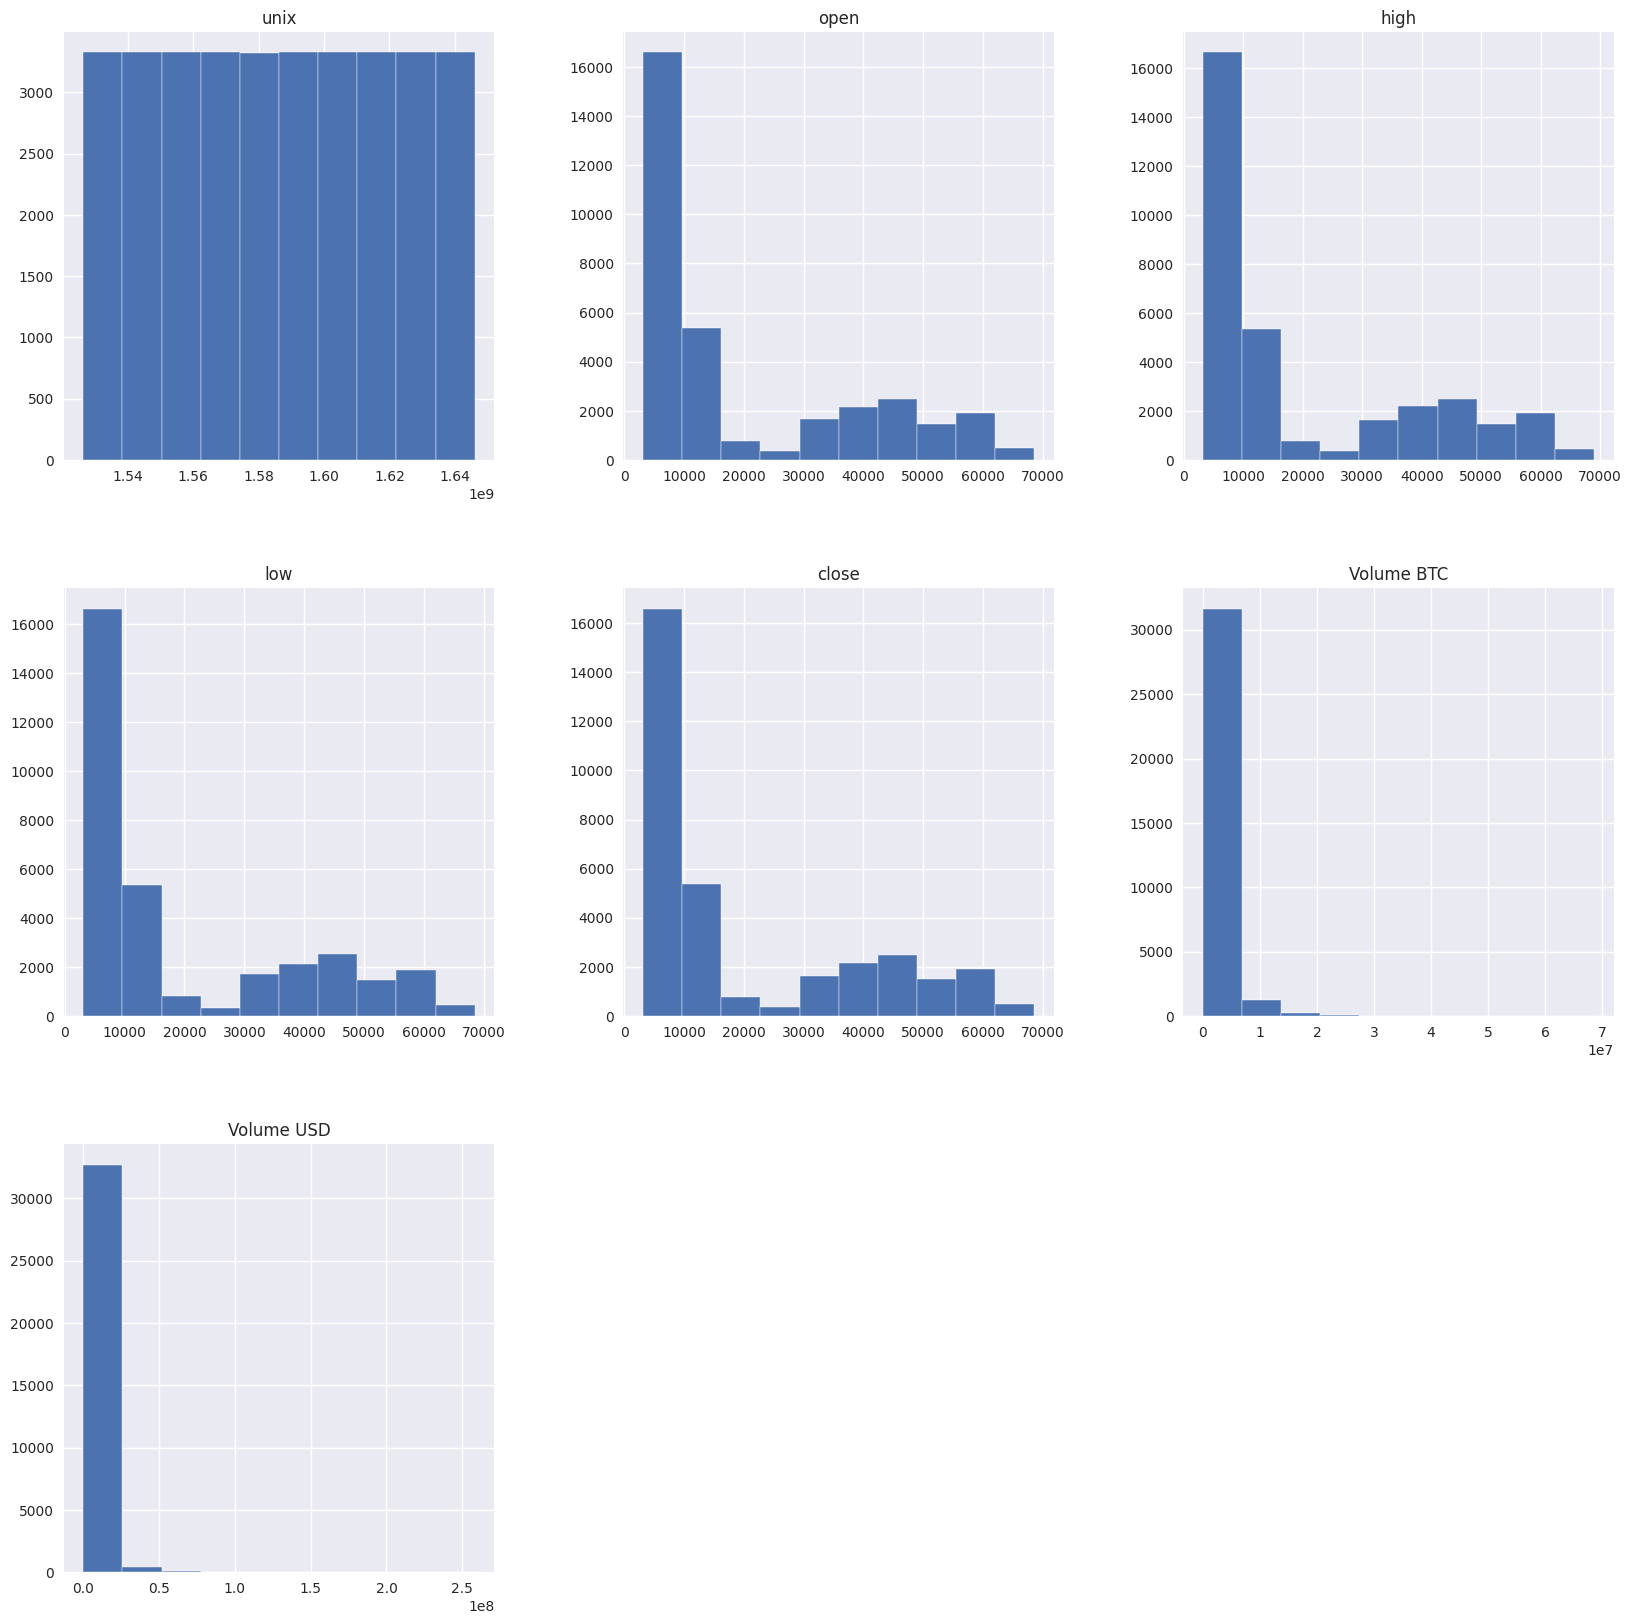

In [9]:
# Displays the distributions of the prices
btcdf_hourly.hist()

array([[<Axes: xlabel='unix', ylabel='unix'>,
        <Axes: xlabel='open', ylabel='unix'>,
        <Axes: xlabel='high', ylabel='unix'>,
        <Axes: xlabel='low', ylabel='unix'>,
        <Axes: xlabel='close', ylabel='unix'>,
        <Axes: xlabel='Volume BTC', ylabel='unix'>,
        <Axes: xlabel='Volume USD', ylabel='unix'>],
       [<Axes: xlabel='unix', ylabel='open'>,
        <Axes: xlabel='open', ylabel='open'>,
        <Axes: xlabel='high', ylabel='open'>,
        <Axes: xlabel='low', ylabel='open'>,
        <Axes: xlabel='close', ylabel='open'>,
        <Axes: xlabel='Volume BTC', ylabel='open'>,
        <Axes: xlabel='Volume USD', ylabel='open'>],
       [<Axes: xlabel='unix', ylabel='high'>,
        <Axes: xlabel='open', ylabel='high'>,
        <Axes: xlabel='high', ylabel='high'>,
        <Axes: xlabel='low', ylabel='high'>,
        <Axes: xlabel='close', ylabel='high'>,
        <Axes: xlabel='Volume BTC', ylabel='high'>,
        <Axes: xlabel='Volume USD', ylabel='high

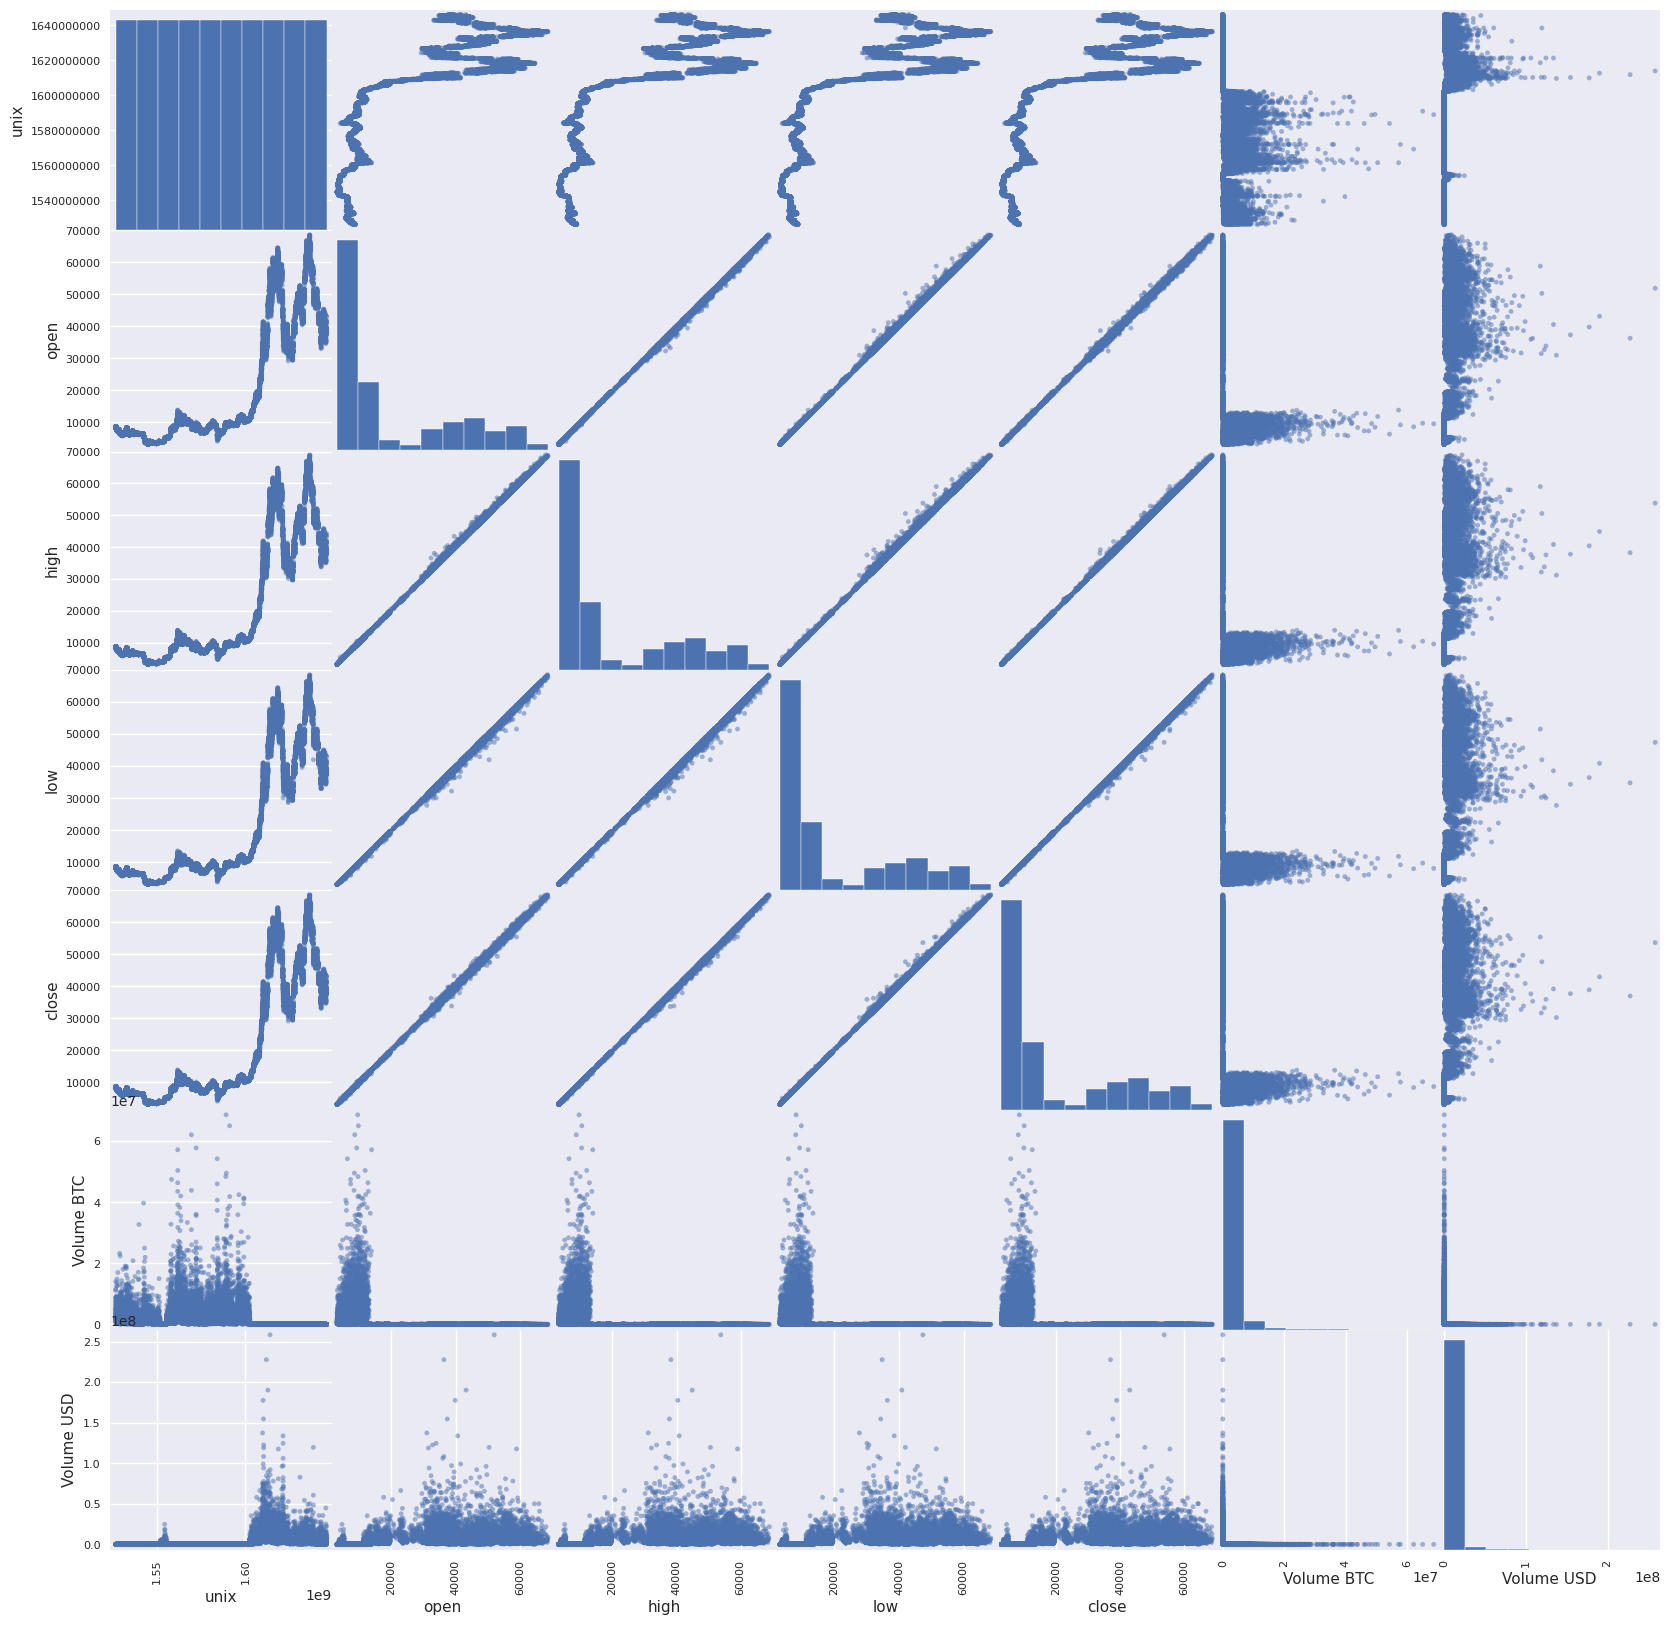

In [10]:
#Plots the scatter matrix showing the relationships between datapoints
scatter_matrix(btcdf_hourly)

In [11]:
# Plots the candlestick timeseries from 2021 to 2022 
btc2021 = btcdf_hourly[btcdf_hourly.date > "2021-01-01"]
layout = dict(
    title_text = "BTC/USD",
    xaxis = dict(title = "Hours"),
    yaxis = dict(title = "BTC/USD Price"),
)
fig  = go.Figure(data = [go.Candlestick(x = btc2021.date, open = btc2021["open"], close = btc2021["close"], high = btc2021["high"], low = btc2021["low"])], layout = layout)
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
)
plt.tight_layout()
fig.show()

<Figure size 2000x2000 with 0 Axes>

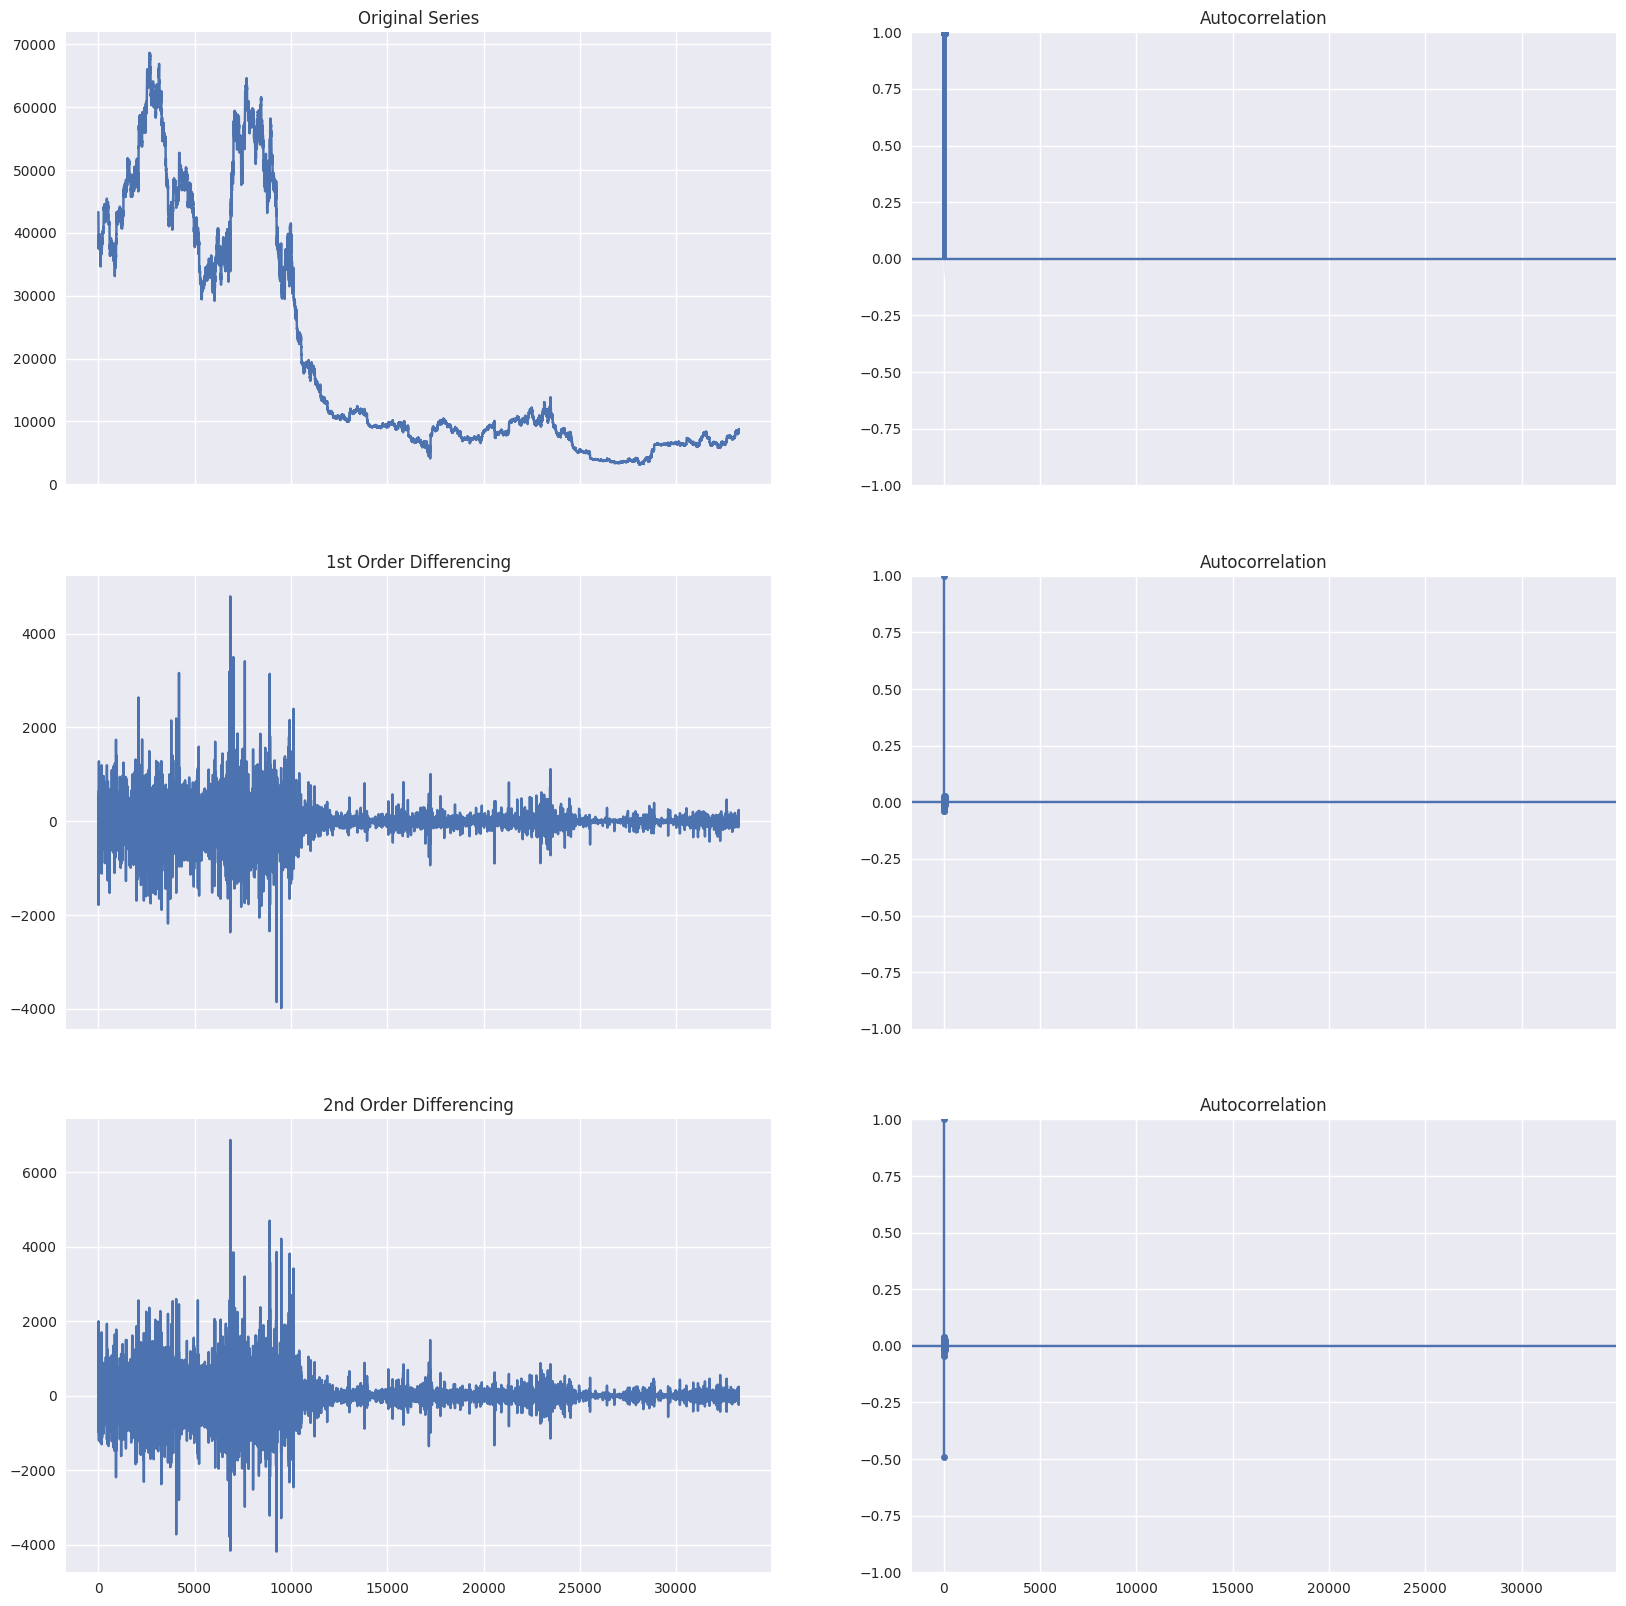

In [12]:
#Determine the number of lags in the system
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(btcdf_hourly["close"].values); axes[0, 0].set_title('Original Series')
plot_acf(btcdf_hourly["close"].values, ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(np.diff(btcdf_hourly["close"].values)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(btcdf_hourly["close"].values), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(btcdf_hourly["close"].values))); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(btcdf_hourly["close"].values)), ax=axes[2, 1])
plt.show()

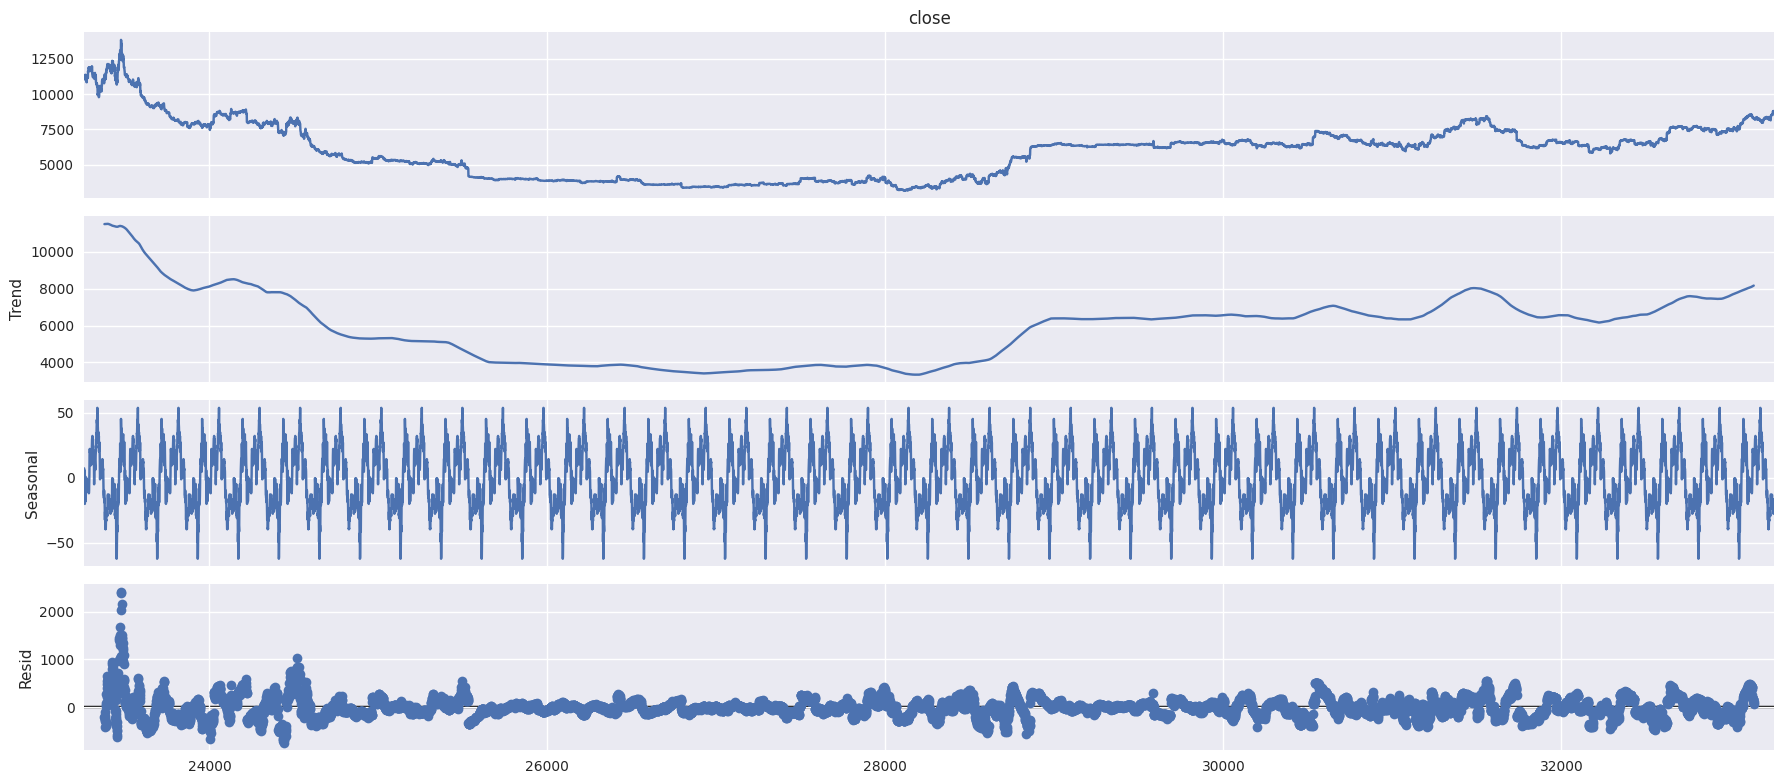

In [13]:
# Plot the sesonal decomposition
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(btcdf_hourly["close"].iloc[-10000:], model='additive', period = 240)
fig = decomposition.plot()
plt.tight_layout()
plt.show()

unix                 date   symbol      open      high       low  \
0  1646092800  2022-03-01 00:00:00  BTC/USD  43221.71  43626.49  43185.48   
1  1646089200  2022-02-28 23:00:00  BTC/USD  43085.30  43364.81  42892.37   
2  1646085600  2022-02-28 22:00:00  BTC/USD  41657.23  44256.08  41650.29   
3  1646082000  2022-02-28 21:00:00  BTC/USD  41917.09  41917.09  41542.60   
4  1646078400  2022-02-28 20:00:00  BTC/USD  41361.99  41971.00  41284.11   

      close  Volume BTC    Volume USD  rolling_mean_diff  
0  43312.27   52.056320  2.254677e+06                NaN  
1  43178.98  106.816103  4.612210e+06                NaN  
2  42907.32  527.540571  2.263535e+07                NaN  
3  41659.53   69.751680  2.905822e+06                NaN  
4  41914.97  247.151654  1.035935e+07                NaN

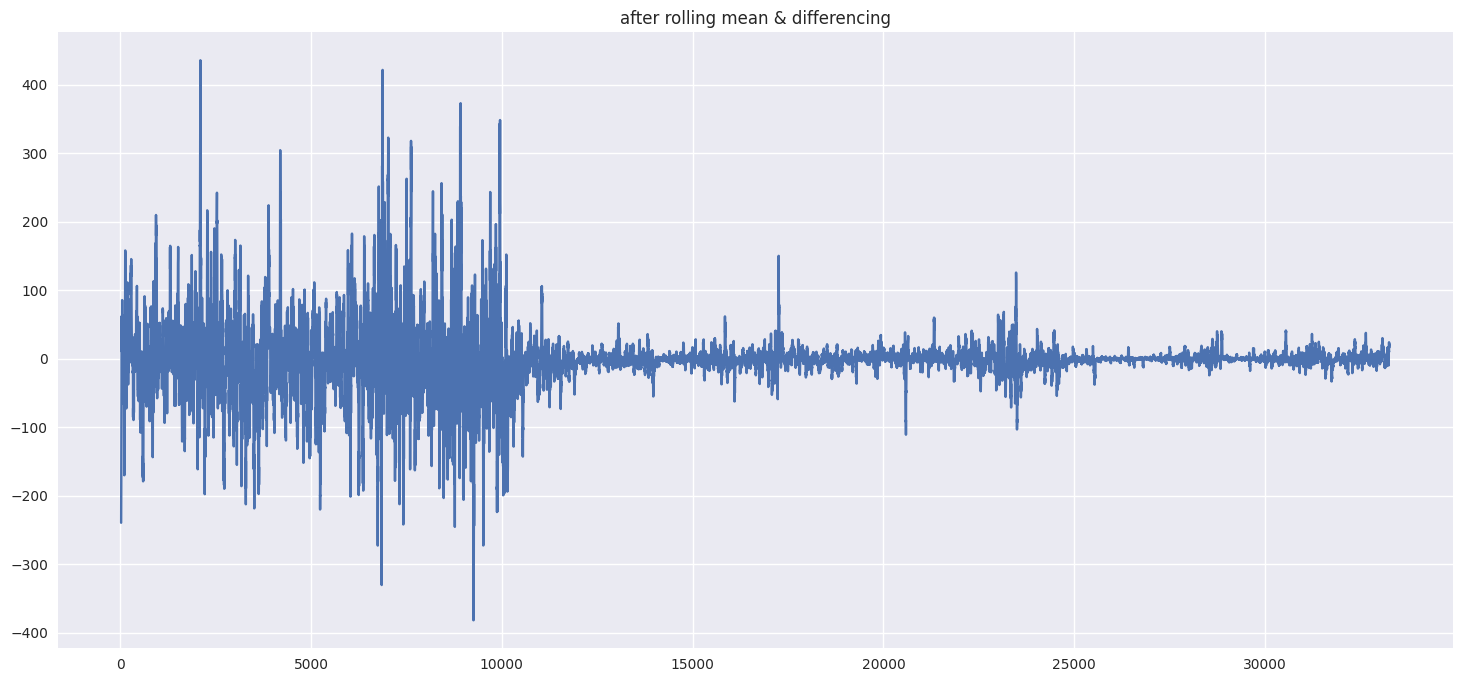

In [14]:
# Compute the differences in the rolling means
rolling_mean = btcdf_hourly["close"].rolling(window = 24).mean()
btcdf_hourly['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
btcdf_hourly['rolling_mean_diff'].plot(title='after rolling mean & differencing')
ax2 = plt.subplot()
btcdf_hourly.head()

In [15]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(btcdf_hourly["close"], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.1780339694461053
2. P-Value :  0.6829728576481299
3. Num Of Lags :  50
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 33208
5. Critical Values :
	 1% :  -3.4305469346408284
	 5% :  -2.8616270400968356
	 10% :  -2.56681632873368


In [16]:
# Creates the feature engineering function
def Feature_Engineering_Generator(df):
    
    # State the length of the sliding window:
    rolling = 24
    
    # Create the copies of the data being used:
    data = df.copy().dropna().drop(columns = ["unix", "symbol"]).reset_index(drop = True)
    
    # Extract the OLCHV data:
    Open, Low, Close, High, Volume_BTC, Volume_USD = data["open"].shift(1), data["low"].shift(1), data["close"].shift(1), data["high"].shift(1), data["Volume BTC"].shift(1), data["Volume USD"].shift(1)
    
    # Generate the target:
    data["returns"] = (data["close"] - data["close"].shift(1))/data["close"].shift(1)
    data["sLow"] = (data["low"] - data["close"].shift(1))/data["close"].shift(1)
    data["sHigh"] = (data["high"] - data["close"].shift(1))/data["close"].shift(1)
    
    # Create an UnFeaturedEngineered Dataset:
    data["unaltered_open"] = data["open"]
    data["unaltered_close"] = data["close"]
    data["unaltered_low"] = data["low"]
    data["unaltered_high"] = data["high"]
    
    data["unaltered_returns"] = data["returns"]
    data["unaltered_sLow"] = data["sLow"]
    data["unaltered_sHigh"] = data["sHigh"]
    
    data["unaltered_returns_means"] = data["returns"].rolling(rolling).mean()
    data["unaltered_returns_stds"] = data["returns"].rolling(rolling).std()
    data["unaltered_close_means"] = data["close"].rolling(rolling).mean()
    data["unaltered_close_stds"] = data["close"].rolling(rolling).std()
    
    #Generate the Features:
    data["returns t-1"] = data["returns"].shift(1)
    data["sLow t-1"] = data["sLow"].shift(1)
    data["sHigh t-1"] = data["sHigh"].shift(1)
    data["open t-1"] = Open
    data["close t-1"] = Close
    data["high t-1"] = High
    data["low t-1"] = Low
    data["volume BTC t-1"] = Volume_BTC
    data["volume USD t-1"] = Volume_USD
    
    # Generate the shadows:
    data["upper_shadow t-1"] = High - np.maximum(Close, Open)
    data["lower_shadow t-1"] = Low - np.minimum(Close, Open)
    
    # Generate the Exponential Moving Average:
    data["ema close t-1"] = data["close t-1"].ewm(com = 0.4).mean()
    data["ema return t-1"] = data["returns t-1"].ewm(com = 0.4).mean()
    data["ema_volume_btc t-1"] = data["volume BTC t-1"].ewm(com = 0.4).mean()
    data["ema_volume_usd t-1"] = data["volume USD t-1"].ewm(com = 0.4).mean()
    
    # Generate the Simple Moving Average
    data["mean return 24 t-1"] = data["returns t-1"].rolling(24).mean()
    data["mean return 50 t-1"] = data["returns t-1"].rolling(50).mean()
    data["mean return 200 t-1"] = data["returns t-1"].rolling(200).mean()
    
    data["volatility return 24 t-1"] = data["returns t-1"].rolling(24).var()
    data["volatility return 50 t-1"] = data["returns t-1"].rolling(50).var()
    data["volatility return 200 t-1"] = data["returns t-1"].rolling(200).var()
    
    data["skew return 24 t-1"] = data["returns t-1"].rolling(24).skew()
    data["skew return 50 t-1"] = data["returns t-1"].rolling(50).skew()
    data["skew return 200 t-1"] = data["returns t-1"].rolling(200).skew()
    
    # Calculate the shifts in volatility
    data["var24 t-1"] = data["close t-1"].pct_change(24)
    data["var50 t-1"] = data["close t-1"].pct_change(50)
    
    # Measure the Amplitudes
    data["Amplitude_6 t-1"] = np.abs(Close - Open).rolling(6).mean()
    data["Amplitude_Skew_6 t-1"] = np.abs(High - Low).rolling(6).mean()
    data["Amplitude_Ratio_6 t-1"] = data["Amplitude_Skew_6 t-1"] - data["Amplitude_6 t-1"]
    
    # Measure the Volume Indicators
    data["Volume Ratio"] = (data["volume BTC t-1"] - data["volume USD t-1"])/data["volume USD t-1"]
    
    # Generate the support levels
    data["Support Level 24 t-1"] = Close.rolling(24).min()
    data["Support Level 50 t-1"] = Close.rolling(50).min()
    
    # Generate the resistance levels
    data["Resistance Level 24 t-1"] = Close.rolling(24).max()
    data["Resistance Level 50 t-1"] = Close.rolling(50).max()
    
    # Calculate the moving correlation
    data["moving correlation t-1"] = data["var50 t-1"].rolling(32).corr(data["var24 t-1"])
    
    # Calculate the RSI 
    data["RSI_24 t-1"] = ta.RSI(Close, timeperiod = 24)
    
    # Calculate the bollinger bands
    data["upperband t-1"], data["middleband t-1"], data["lowerband t-1"] = ta.BBANDS(Close)
    
    # Calculate the Double Exponential Moving Average
    data["DEMA t-1"] = ta.DEMA(Close)
    
    # Calculate the Parabolic SAR
    data["Parabolic_SAR t-1"] = ta.SAR(High, Low)
    
    # Calculate the Moving Average Convergence/Divergence
    data["MACD t-1"], _, _ = ta.MACD(Close)
    
    # Calculate the Average Directional Movement Index
    data["ADX t-1"] = ta.ADX(High, Low, Close)
    
    # Creating the dataframes
    subset = data.drop(columns = ["date", "unaltered_open", "unaltered_close", "unaltered_low", "unaltered_high", "unaltered_returns", "unaltered_sLow","unaltered_sHigh","unaltered_returns_means", "unaltered_returns_stds", "unaltered_close_means", "unaltered_close_stds"])
    mean = subset - subset.rolling(rolling).mean()
    std = np.maximum(subset.rolling(rolling).std(), 1e-3)
    data = pd.concat([data["date"],mean/std, data[["unaltered_open", "unaltered_close", "unaltered_low", "unaltered_high", "unaltered_returns", "unaltered_sLow","unaltered_sHigh","unaltered_returns_means", "unaltered_returns_stds", "unaltered_close_means", "unaltered_close_stds"]]], axis = 1)
    
    # Cleaning the data
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace = True)
    
    # Slicing the data into relevant dataframes
    X = data.drop(columns = ["returns","close", "open", "high", "low","sHigh","sLow","Volume BTC", "Volume USD", "Volume BTC", "rolling_mean_diff", "unaltered_open", "unaltered_close", "unaltered_low", "unaltered_high", "unaltered_returns", "unaltered_sLow","unaltered_sHigh","unaltered_returns_means", "unaltered_returns_stds", "unaltered_close_means", "unaltered_close_stds"])
    Unaltered = data[["unaltered_open", "unaltered_close", "unaltered_low", "unaltered_high", "unaltered_returns", "unaltered_sLow","unaltered_sHigh","unaltered_returns_means", "unaltered_returns_stds", "unaltered_close_means", "unaltered_close_stds"]]
    y = data[["close", "returns"]]
    return data.iloc[::-1],X.iloc[::-1],y.iloc[::-1], Unaltered.iloc[::-1]

In [17]:
# Generates the feature engineered dataset
Dataset,X,y, unaltered = Feature_Engineering_Generator(btcdf_hourly)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32960 entries, 33234 to 224
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       32960 non-null  object 
 1   returns t-1                32960 non-null  float64
 2   sLow t-1                   32960 non-null  float64
 3   sHigh t-1                  32960 non-null  float64
 4   open t-1                   32960 non-null  float64
 5   close t-1                  32960 non-null  float64
 6   high t-1                   32960 non-null  float64
 7   low t-1                    32960 non-null  float64
 8   volume BTC t-1             32960 non-null  float64
 9   volume USD t-1             32960 non-null  float64
 10  upper_shadow t-1           32960 non-null  float64
 11  lower_shadow t-1           32960 non-null  float64
 12  ema close t-1              32960 non-null  float64
 13  ema return t-1             32960 non-null  float6

In [18]:
# DIsplay the information regarding the unaltered variables of the unaltered matrix
unaltered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32960 entries, 33234 to 224
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   unaltered_open           32960 non-null  float64
 1   unaltered_close          32960 non-null  float64
 2   unaltered_low            32960 non-null  float64
 3   unaltered_high           32960 non-null  float64
 4   unaltered_returns        32960 non-null  float64
 5   unaltered_sLow           32960 non-null  float64
 6   unaltered_sHigh          32960 non-null  float64
 7   unaltered_returns_means  32960 non-null  float64
 8   unaltered_returns_stds   32960 non-null  float64
 9   unaltered_close_means    32960 non-null  float64
 10  unaltered_close_stds     32960 non-null  float64
dtypes: float64(11)
memory usage: 3.0 MB


In [19]:
# Check for signs of data leakage
Dataset[["close", "open t-1"]]

close  open t-1
33234  1.064983  1.064983
33233  1.142662  1.142662
33232  1.188255  1.188255
33231  1.191402  1.191402
33230  1.730860  1.730860
...         ...       ...
228    1.667524  1.779947
227    1.540989  1.576105
226    2.224451  2.333767
225   -1.273813 -1.469127
224   -0.853802 -0.676365

[32960 rows x 2 columns]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



<Axes: xlabel='returns', ylabel='close'>

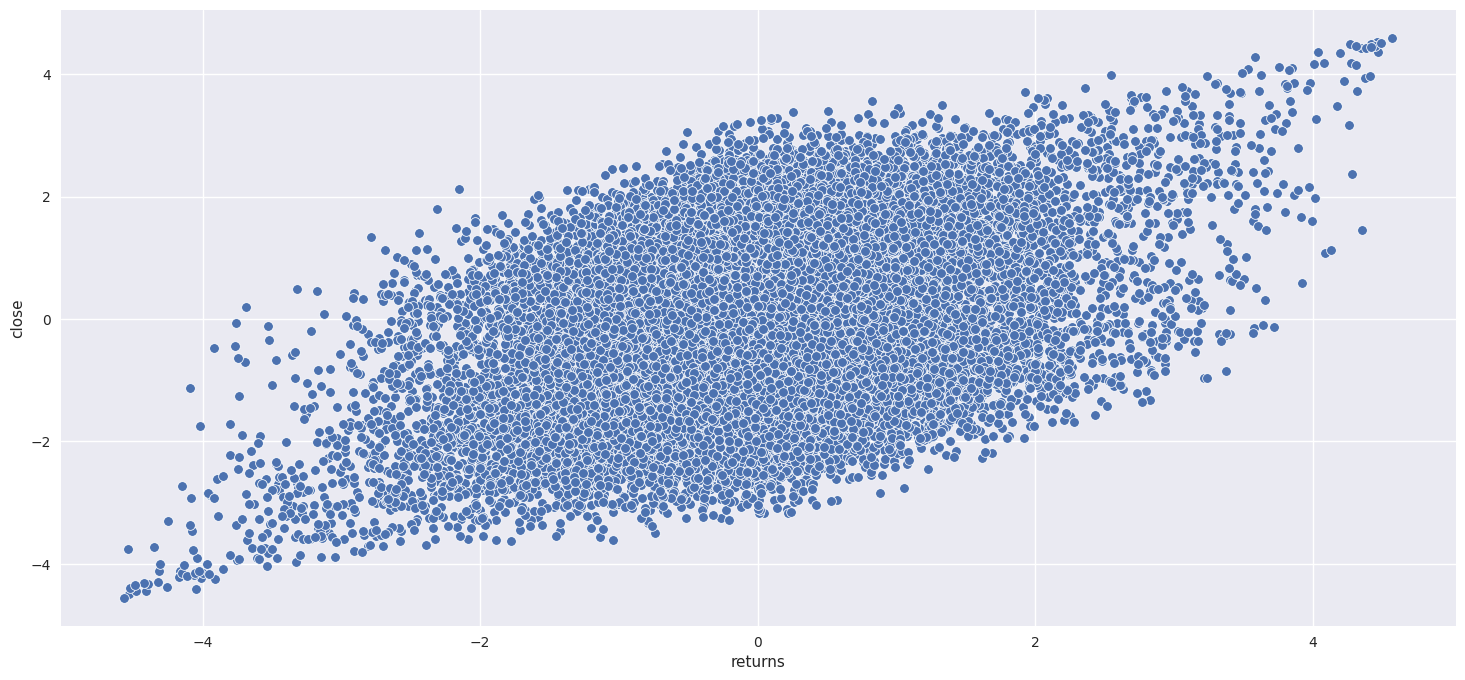

In [21]:
# Plot the relationship between the returns and close
sns.scatterplot(data = Dataset, x = "returns", y = "close")

In [22]:
# Displays the first 20 rows of the feature matrix
X.head(20)

date  returns t-1  sLow t-1  sHigh t-1  open t-1  \
33234  2018-05-15 06:00:00    -0.151892  0.260631  -0.499411  1.064983   
33233  2018-05-15 07:00:00    -0.033072 -0.261687  -0.459543  1.142662   
33232  2018-05-15 08:00:00    -1.395301 -0.845647  -1.299012  1.188255   
33231  2018-05-15 09:00:00     0.217132 -0.412460   0.213079  1.191402   
33230  2018-05-15 10:00:00    -0.209554  0.165562  -0.205083  1.730860   
33229  2018-05-15 11:00:00    -0.204424  0.173300  -0.424297  1.762077   
33228  2018-05-15 12:00:00     2.523055  2.166319   1.585141  1.990977   
33227  2018-05-15 13:00:00    -0.207427 -0.216805   1.578513  2.295423   
33226  2018-05-15 14:00:00    -0.334640 -0.233275  -0.554036  1.021755   
33225  2018-05-15 15:00:00    -0.299787 -0.093433  -0.344905  1.128759   
33224  2018-05-15 16:00:00     0.117904  0.148114  -0.235363  1.333761   
33223  2018-05-15 17:00:00    -0.526775 -1.319175  -0.789018  1.546933   
33222  2018-05-15 18:00:00     0.407156 -0.336933  -0.093493  1.563519   
33221  2018-05-15 19:00:00     0.141631  0.014537  -0.029786  1.979659   
33220  2018-05-15 20:00:00     0.316299  0.650878   0.186924  1.891759   
33219  2018-05-15 21:00:00    -0.307093 -0.237979   0.072078  1.956795   
33218  2018-05-15 22:00:00     0.174964  0.352020  -0.260904  1.889047   
33217  2018-05-15 23:00:00     1.665583  1.727433   1.127424  2.333119   
33216  2018-05-16 00:00:00     2.829060  2.469919   3.098181  2.445465   
33215  2018-05-16 01:00:00    -0.395780 -0.199376   1.813768  0.849829   

       close t-1  high t-1   low t-1  volume BTC t-1  volume USD t-1  ...  \
33234   1.142662  1.011576  1.270900       -0.849601       -0.862961  ...   
33233   1.188255  1.012410  1.091336        0.774855        0.709537  ...   
33232   1.191402  1.116277  1.386310       -1.041948       -1.052125  ...   
33231   1.730860  1.752579  1.492745        1.748364        1.610095  ...   
33230   1.762077  1.746897  1.891836       -0.669499       -0.699006  ...   
33229   1.990977  1.842547  2.160702       -0.666556       -0.697987  ...   
33228   2.295423  1.930335  2.269846        0.430156        0.350180  ...   
33227   1.021755  2.156415  1.016319        1.944285        1.852579  ...   
33226   1.128759  0.977863  1.179139        0.667101        0.612278  ...   
33225   1.333761  1.314402  1.453086       -0.451563       -0.475023  ...   
33224   1.546933  1.369187  1.601551       -0.187146       -0.220690  ...   
33223   1.563519  1.313119  0.982912        0.838408        0.782763  ...   
33222   1.979659  1.669863  1.469661        0.354707        0.307116  ...   
33221   1.891759  1.741578  1.707722        0.237040        0.194356  ...   
33220   1.956795  1.830988  2.104047       -0.919869       -0.926625  ...   
33219   1.889047  2.104480  1.812412       -0.546629       -0.562271  ...   
33218   2.333119  1.811767  2.354368       -1.006830       -1.010122  ...   
33217   2.445465  2.029117  2.548493       -0.974583       -0.979294  ...   
33216   0.849829  1.907966  0.701197        1.445816        1.414569  ...   
33215  -2.017788  0.105437 -1.846415        3.269120        3.298249  ...   

       Resistance Level 50 t-1  moving correlation t-1  RSI_24 t-1  \
33234                 1.481377                1.396225    0.756492   
33233                 1.632057                1.534974    0.777983   
33232                 1.817570                1.697651    0.760262   
33231                 2.055739                1.873941    1.538361   
33230                 2.100910                1.932667    1.555675   
33229                 2.447694                2.030768    1.717162   
33228                 2.974753                2.126080    1.917299   
33227                 1.422286                2.025980    0.800631   
33226                 1.569585                1.918420    0.897391   
33225                 1.748643                1.595550    1.114705   
33224                 1.975417                0.959806    1.322621   
33223    

In [23]:
#Display Targets
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32960 entries, 33234 to 224
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   close    32960 non-null  float64
 1   returns  32960 non-null  float64
dtypes: float64(2)
memory usage: 772.5 KB


array([[<Axes: title={'center': 'returns t-1'}>,
        <Axes: title={'center': 'sLow t-1'}>,
        <Axes: title={'center': 'sHigh t-1'}>,
        <Axes: title={'center': 'open t-1'}>,
        <Axes: title={'center': 'close t-1'}>,
        <Axes: title={'center': 'high t-1'}>,
        <Axes: title={'center': 'low t-1'}>],
       [<Axes: title={'center': 'volume BTC t-1'}>,
        <Axes: title={'center': 'volume USD t-1'}>,
        <Axes: title={'center': 'upper_shadow t-1'}>,
        <Axes: title={'center': 'lower_shadow t-1'}>,
        <Axes: title={'center': 'ema close t-1'}>,
        <Axes: title={'center': 'ema return t-1'}>,
        <Axes: title={'center': 'ema_volume_btc t-1'}>],
       [<Axes: title={'center': 'ema_volume_usd t-1'}>,
        <Axes: title={'center': 'mean return 24 t-1'}>,
        <Axes: title={'center': 'mean return 50 t-1'}>,
        <Axes: title={'center': 'mean return 200 t-1'}>,
        <Axes: title={'center': 'volatility return 24 t-1'}>,
        <Axes:

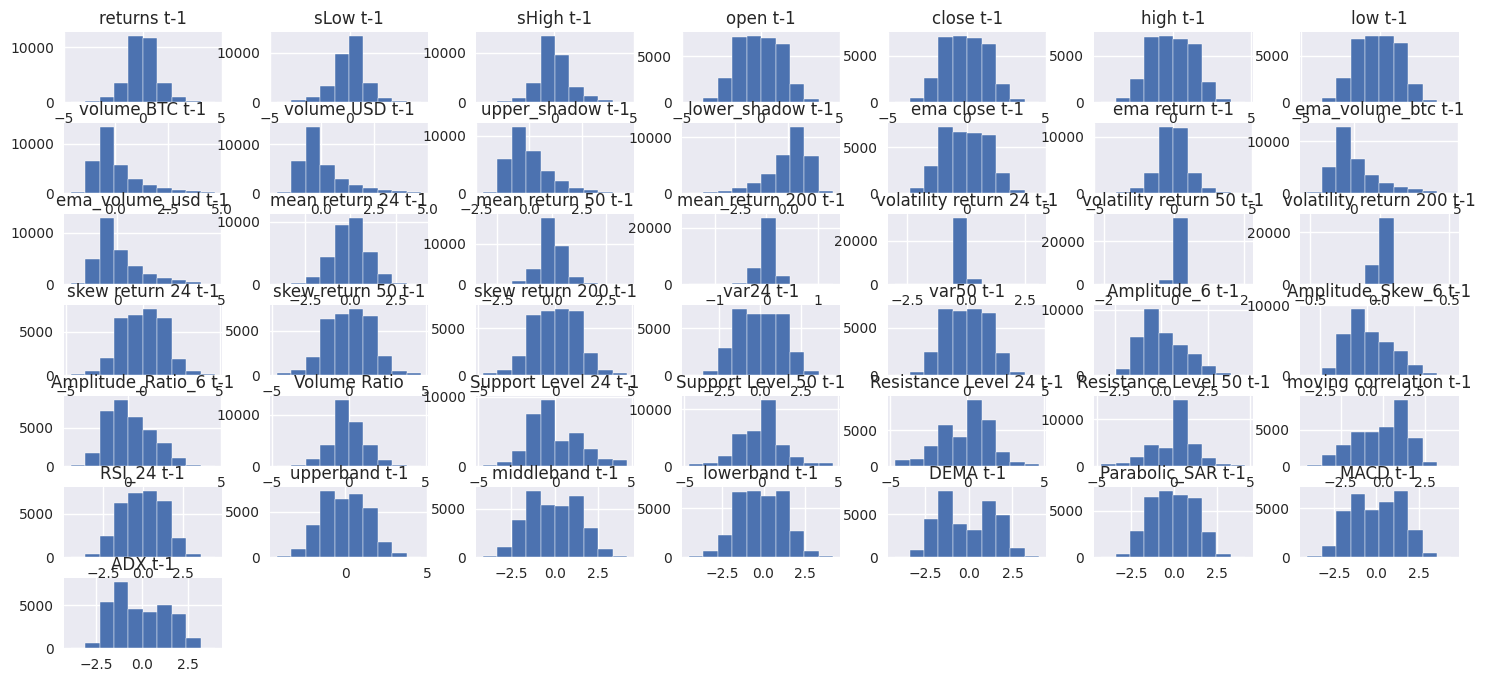

In [24]:
# Display the distributions of the feature matrix
X.hist()

In [26]:
# Strength of correlations associated with the close.
np.abs(Dataset.drop(columns = ["date"]).corr()["close"].sort_values(ascending = False))

close               1.000000
open t-1            0.999664
high                0.923594
low                 0.919303
high t-1            0.908004
                      ...   
Amplitude_6 t-1     0.034713
upper_shadow t-1    0.037176
Volume USD          0.042288
Volume BTC          0.043764
ADX t-1             0.172871
Name: close, Length: 64, dtype: float64

In [27]:
# Strength of the correlations associated 
np.abs(Dataset.drop(columns = ["date"]).corr()["returns"].sort_values(ascending = False))

returns              1.000000
unaltered_returns    0.805934
sHigh                0.791298
sLow                 0.779460
unaltered_sHigh      0.623034
                       ...   
DEMA t-1             0.174865
lower_shadow t-1     0.187441
ema close t-1        0.189233
close t-1            0.192777
Parabolic_SAR t-1    0.207991
Name: returns, Length: 64, dtype: float64

array([[<Axes: xlabel='close', ylabel='close'>,
        <Axes: xlabel='open t-1', ylabel='close'>,
        <Axes: xlabel='close t-1', ylabel='close'>,
        <Axes: xlabel='high t-1', ylabel='close'>],
       [<Axes: xlabel='close', ylabel='open t-1'>,
        <Axes: xlabel='open t-1', ylabel='open t-1'>,
        <Axes: xlabel='close t-1', ylabel='open t-1'>,
        <Axes: xlabel='high t-1', ylabel='open t-1'>],
       [<Axes: xlabel='close', ylabel='close t-1'>,
        <Axes: xlabel='open t-1', ylabel='close t-1'>,
        <Axes: xlabel='close t-1', ylabel='close t-1'>,
        <Axes: xlabel='high t-1', ylabel='close t-1'>],
       [<Axes: xlabel='close', ylabel='high t-1'>,
        <Axes: xlabel='open t-1', ylabel='high t-1'>,
        <Axes: xlabel='close t-1', ylabel='high t-1'>,
        <Axes: xlabel='high t-1', ylabel='high t-1'>]], dtype=object)

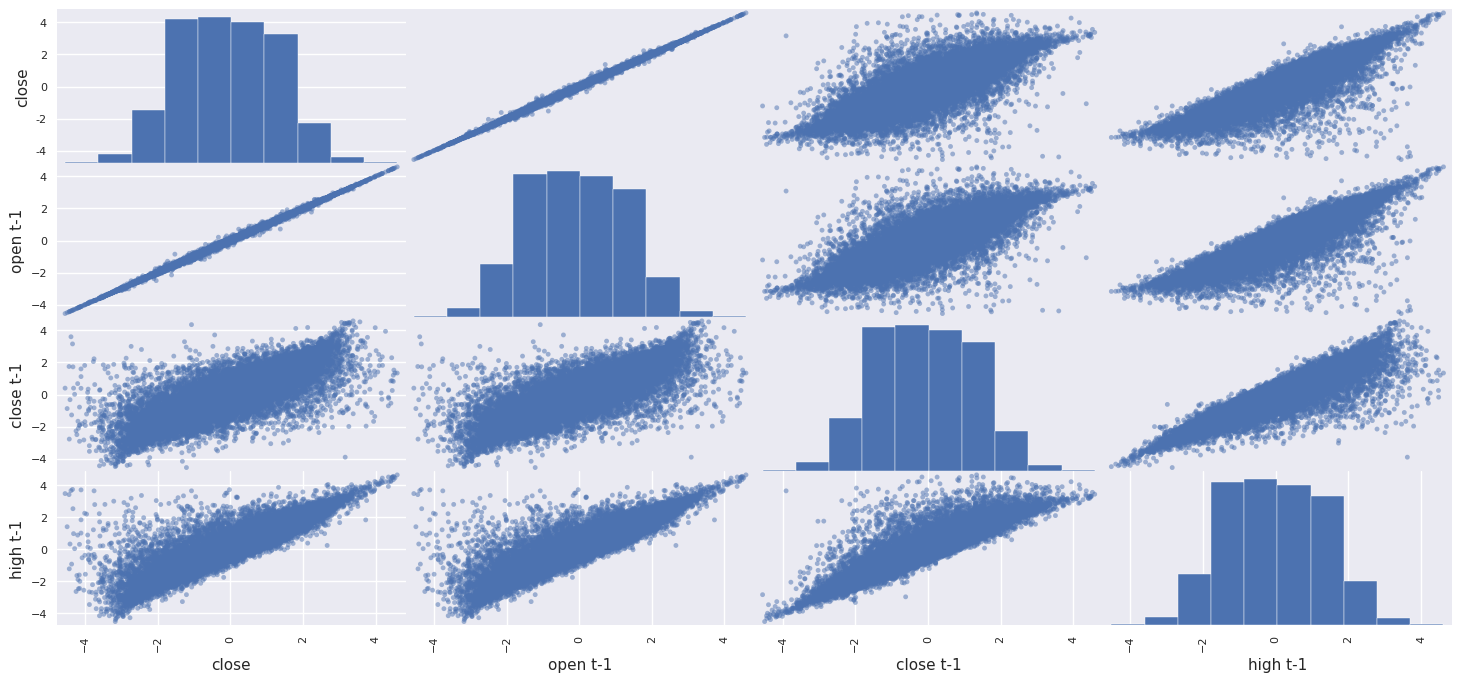

In [28]:
# Plot the relationships to gauage the strength of the correlation
scatter_matrix(Dataset[["close", "open t-1", "close t-1", "high t-1"]])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



<Axes: xlabel='close t-1', ylabel='close'>

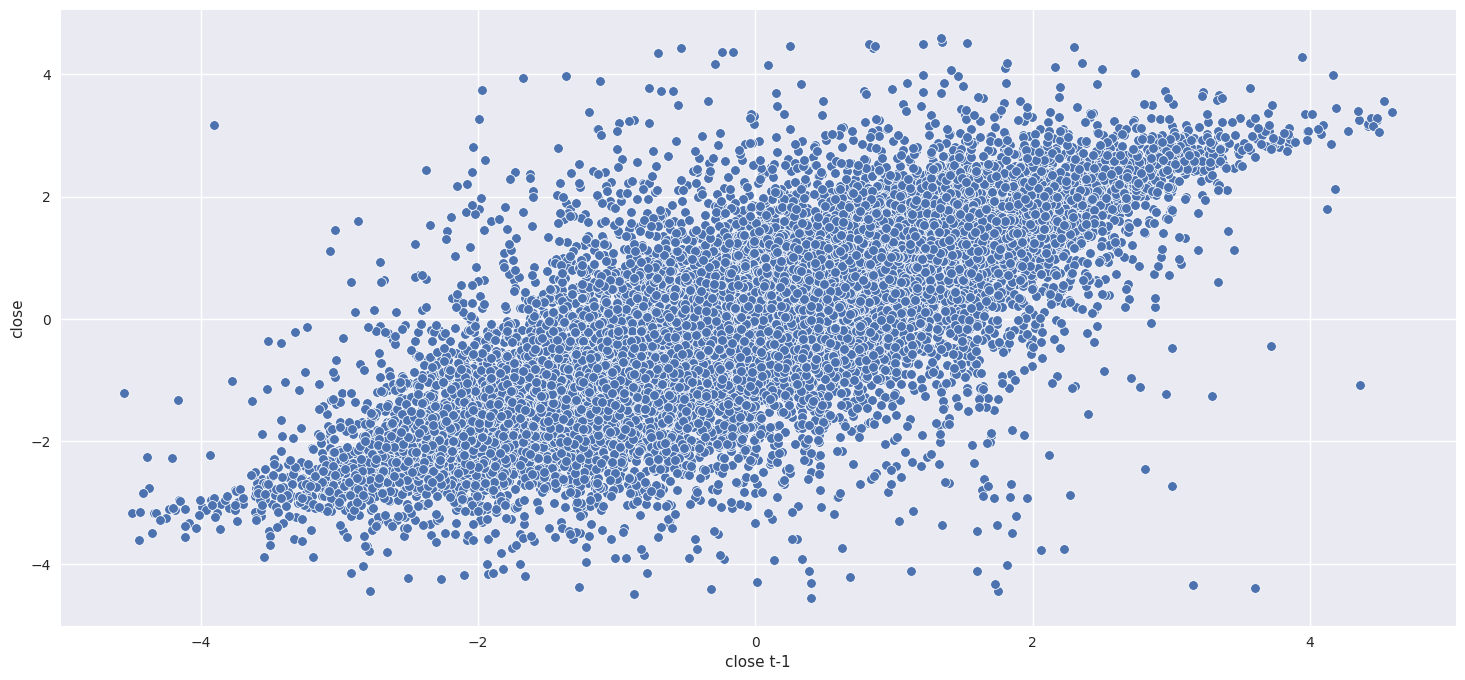

In [29]:
# The relationship between the previous' hours close and the current close
sns.scatterplot(data = Dataset, x = "close t-1", y = "close")

array([[<Axes: xlabel='returns', ylabel='returns'>,
        <Axes: xlabel='open t-1', ylabel='returns'>,
        <Axes: xlabel='high t-1', ylabel='returns'>,
        <Axes: xlabel='var50 t-1', ylabel='returns'>],
       [<Axes: xlabel='returns', ylabel='open t-1'>,
        <Axes: xlabel='open t-1', ylabel='open t-1'>,
        <Axes: xlabel='high t-1', ylabel='open t-1'>,
        <Axes: xlabel='var50 t-1', ylabel='open t-1'>],
       [<Axes: xlabel='returns', ylabel='high t-1'>,
        <Axes: xlabel='open t-1', ylabel='high t-1'>,
        <Axes: xlabel='high t-1', ylabel='high t-1'>,
        <Axes: xlabel='var50 t-1', ylabel='high t-1'>],
       [<Axes: xlabel='returns', ylabel='var50 t-1'>,
        <Axes: xlabel='open t-1', ylabel='var50 t-1'>,
        <Axes: xlabel='high t-1', ylabel='var50 t-1'>,
        <Axes: xlabel='var50 t-1', ylabel='var50 t-1'>]], dtype=object)

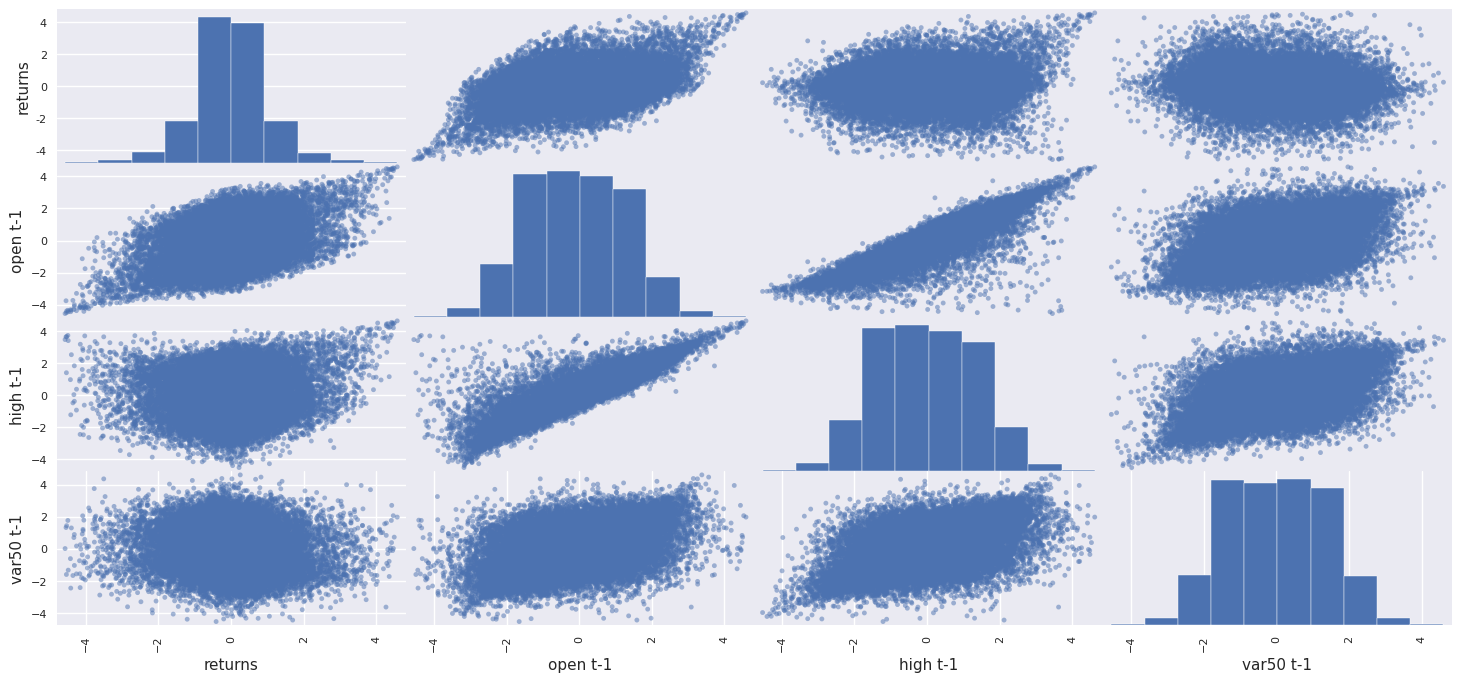

In [30]:
# Plot the relationships to gauage the strength of the correlation
scatter_matrix(Dataset[["returns", "open t-1", "high t-1", "var50 t-1"]])

In [31]:
# Make mutual information scores:
mi_scores_close = make_mi_scores(Dataset.drop(columns = ["date"]), Dataset.drop(columns = ["date"])["close"])
mi_scores_close

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

close                        9.146917
open t-1                     6.159474
high                         1.256483
low                          1.227656
high t-1                     1.191928
                               ...   
volatility return 200 t-1    0.009447
volatility return 24 t-1     0.009426
lower_shadow t-1             0.008412
Volume USD                   0.008019
Volume BTC                   0.006818
Name: MI Scores, Length: 64, dtype: float64

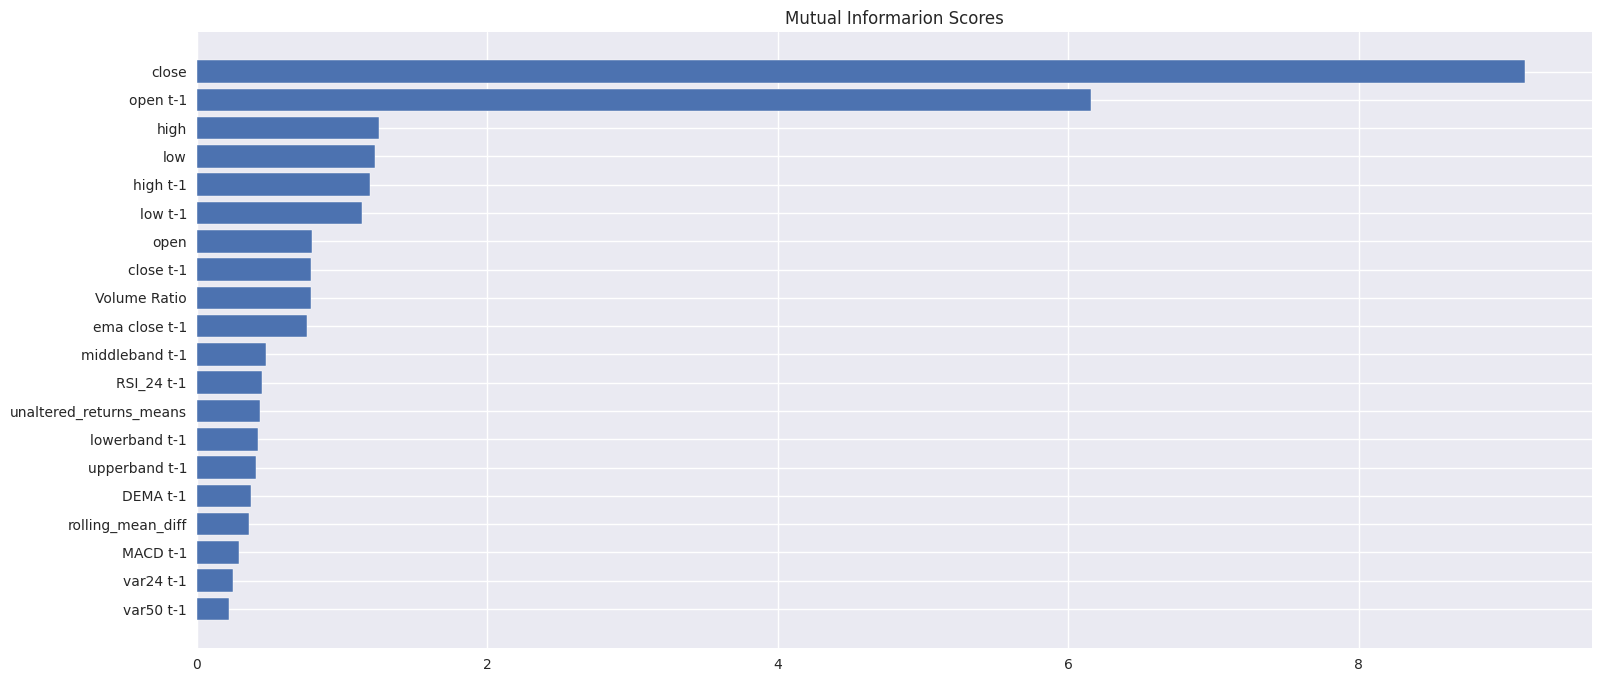

In [32]:
# Plot the mutual information scores
plt.Figure(dpi = 200, figsize = (12,12))
plot_mi_scores(mi_scores_close[:20])

In [33]:
# Make mutual information scores:
mi_scores_returns = make_mi_scores(Dataset.drop(columns = ["date"]), Dataset.drop(columns = ["date"])["returns"])
mi_scores_returns

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

returns                   9.146927
unaltered_returns         0.955179
sHigh                     0.708715
sLow                      0.676579
unaltered_sHigh           0.446634
                            ...   
ema return t-1            0.002000
skew return 200 t-1       0.001368
skew return 24 t-1        0.000162
moving correlation t-1    0.000000
skew return 50 t-1        0.000000
Name: MI Scores, Length: 64, dtype: float64

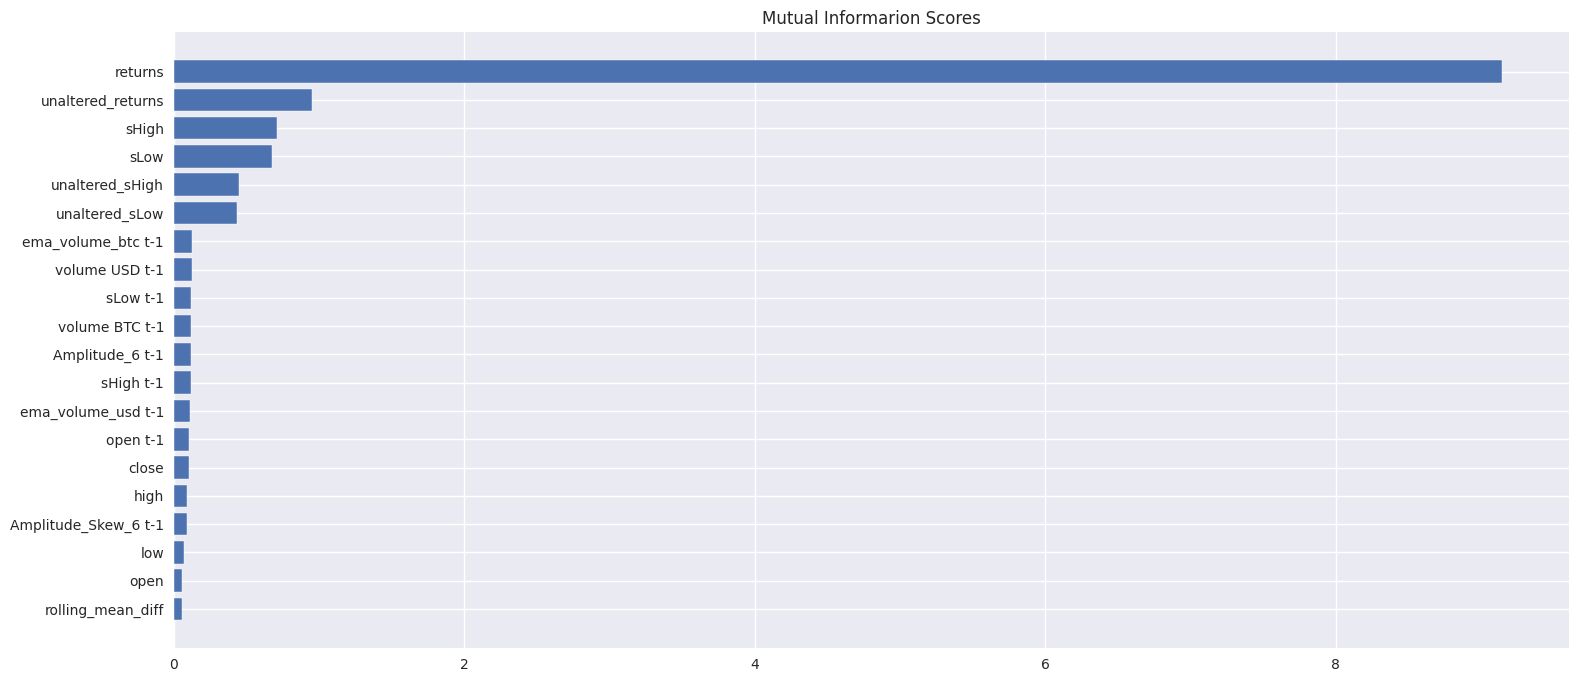

In [34]:
# Plot the mutual information scores
plt.Figure(dpi = 200, figsize = (12,12))
plot_mi_scores(mi_scores_returns[:20])

In [35]:
# Split into training, validation and test scores
X_train, X_test, y_train, y_test = X.iloc[:-1000].reset_index(drop = True).reset_index(drop = True), X.iloc[-1000:].reset_index(drop = True).reset_index(drop = True).reset_index(drop = True), y.iloc[:-1000].reset_index(drop = True).reset_index(drop = True), y.iloc[-1000:].reset_index(drop = True).reset_index(drop = True)
train_unaltered, test_unaltered = unaltered[:-1000].reset_index(drop = True).reset_index(drop = True), unaltered[-1000:].reset_index(drop = True).reset_index(drop = True)

In [36]:
# Review the training dataset
X_train

date  returns t-1  sLow t-1  sHigh t-1  open t-1  \
0      2018-05-15 06:00:00    -0.151892  0.260631  -0.499411  1.064983   
1      2018-05-15 07:00:00    -0.033072 -0.261687  -0.459543  1.142662   
2      2018-05-15 08:00:00    -1.395301 -0.845647  -1.299012  1.188255   
3      2018-05-15 09:00:00     0.217132 -0.412460   0.213079  1.191402   
4      2018-05-15 10:00:00    -0.209554  0.165562  -0.205083  1.730860   
...                    ...          ...       ...        ...       ...   
31955  2022-01-07 20:00:00     1.287012  1.541454   0.884049  0.521869   
31956  2022-01-07 21:00:00     0.089221  0.059291   0.516604  0.491383   
31957  2022-01-07 22:00:00    -1.675058 -1.366667  -1.783855 -0.301753   
31958  2022-01-07 23:00:00     0.233867 -0.560808  -0.110314 -0.261156   
31959  2022-01-08 00:00:00     0.110728  0.432446   0.439757  0.644989   

       close t-1  high t-1   low t-1  volume BTC t-1  volume USD t-1  ...  \
0       1.142662  1.011576  1.270900       -0.849601       -0.862961  ...   
1       1.188255  1.012410  1.091336        0.774855        0.709537  ...   
2       1.191402  1.116277  1.386310       -1.041948       -1.052125  ...   
3       1.730860  1.752579  1.492745        1.748364        1.610095  ...   
4       1.762077  1.746897  1.891836       -0.669499       -0.699006  ...   
...          ...       ...       ...             ...             ...  ...   
31955   0.503063  0.493332  0.759687       -0.553219       -0.555171  ...   
31956  -0.296049  0.046281 -0.290447        0.397844        0.405994  ...   
31957  -0.349560 -0.876133 -0.363446       -0.302567       -0.303034  ...   
31958   0.681850  0.611251  0.123493       -0.025596       -0.011937  ...   
31959   0.550127  1.045573  0.767930       -0.273856       -0.266775  ...   

       Resistance Level 50 t-1  moving correlation t-1  RSI_24 t-1  \
0                     1.481377                1.396225    0.756492   
1                     1.632057                1.534974    0.777983   
2                     1.817570                1.697651    0.760262   
3                     2.055739                1.873941    1.538361   
4                     2.100910                1.932667    1.555675   
...                        ...                     ...         ...   
31955                 0.000000                1.080487    0.472909   
31956                 0.000000                1.136188   -0.502370   
31957                 0.000000                1.210740   -0.560297   
31958                 0.000000                1.332493    0.714763   
31959                 0.000000                1.470769    0.564873   

       upperband t-1  middleband t-1  lowerband t-1  DEMA t-1  \
0           1.105491        1.476187       1.576505  1.798864   
1           1.225745        1.655142       1.771304  1.895111   
2           1.348699        1.891252       2.057082  2.007862   
3           2.052106        1.926469       1.318819  2.154057   
4           2.259726        1.838922       0.924594  2.202270   
...              ...             ...            ...       ...   
31955       0.391176        0.271005       0.172304  0.894616   
31956       0.422879        0.264661       0.153659  0.799234   
31957       0.309455        0.403049       0.344599  0.971372   
31958      -0.283241        0.615894       0.773984  1.189487   
31959      -0.365078        0.603157       0.795030  1.071808   

       Parabolic_SAR t-1  MACD t-1   ADX t-1  
0               2.240006  1.277486  1.544490  
1               2.673308  1.424237  1.704968  
2               1.981268  1.593691  1.941357  
3               1.900638  1.817956  2.081771  
4               1.742190  1.859701  2.236861  
...                  ...       ...       ...  
31955           1.071557  0.413110 -1.142776  
31956           1.103056  0.356357 -1.165263  
31957           1.247324  0.602816 -1.064701  
31958           1.258845  0.937644 -1.331859  
31959           0.121652  0.938570 -1.378043  

[31960 rows x 44 colu

In [37]:
# Review the unaltered dataset
unaltered.iloc[:-1000]

unaltered_open  unaltered_close  unaltered_low  unaltered_high  \
33234         8733.86          8740.99        8707.28         8796.68   
33233         8740.99          8739.00        8721.11         8766.00   
33232         8739.00          8728.49        8660.53         8750.27   
33231         8728.49          8708.32        8701.35         8754.40   
33230         8708.32          8795.90        8695.11         8865.00   
...               ...              ...            ...             ...   
1228         41791.70         41903.38       41588.88        42040.00   
1227         41922.49         41890.55       41850.10        42027.89   
1226         41882.92         41543.08       41350.00        41882.92   
1225         41543.08         41535.66       41333.65        41588.69   
1224         41576.73         41986.53       41566.08        42105.00   

       unaltered_returns  unaltered_sLow  unaltered_sHigh  \
33234           0.000228       -0.003630         0.006600   
33233           0.001204       -0.000846         0.004297   
33232           0.002316       -0.005488         0.004817   
33231          -0.009957       -0.010749        -0.004718   
33230           0.004098       -0.007408         0.011986   
...                  ...             ...              ...   
1228            0.000306       -0.007201         0.003568   
1227            0.008364        0.007390         0.011670   
1226            0.000179       -0.004470         0.008361   
1225           -0.010738       -0.015550        -0.009475   
1224            0.001606       -0.008424         0.004432   

       unaltered_returns_means  unaltered_returns_stds  unaltered_close_means  \
33234                 0.002504                0.008695            8527.641250   
33233                 0.002524                0.008690            8506.716667   
33232                 0.002603                0.008687            8485.632917   
33231                 0.002325                0.008802            8463.924167   
33230                 0.002104                0.009182            8444.554583   
...                        ...                     ...                    ...   
1228                  0.000970                0.004705           41713.552083   
1227                  0.000108                0.006415           41673.841250   
1226                 -0.000374                0.006199           41670.149167   
1225                 -0.000136                0.006330           41686.552917   
1224                  0.000217                0.005936           41693.015833   

       unaltered_close_stds  
33234            200.330596  
33233            203.282568  
33232            204.381316  
33231            205.132896  
33230            202.988950  
...                     ...  
1228             404.295632  
1227             430.778153  
1226             429.216944  
1225             431.665498  
1224             430.467592  

[31960 rows x 11 columns]

In [40]:
# Transform the 2d timeseries data into 3d lag timeseries data
def X_3d_RNN(X_s, y_s, lag):
    
    # Simple verification
    if len(X_s) != len(y_s):
        print("Warning")
    
    # Create the X_train
    X_Train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s.iloc[i - lag:i, variable])
        X_Train.append(X)
    X_Train = np.array(X_Train)
    X_Train = np.swapaxes(np.swapaxes(X_Train, 0, 1),1,2)
    
    # Create Y-train
    Y_Train = []
    for i in range(lag, y_s.shape[0]):
        Y_Train.append(y_s[i,:].reshape(-1,1).transpose())
    Y_Train = np.concatenate(Y_Train, axis = 0)
    return X_Train, Y_Train

In [41]:
# Review the training dataset
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31960 entries, 0 to 31959
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       31960 non-null  object 
 1   returns t-1                31960 non-null  float64
 2   sLow t-1                   31960 non-null  float64
 3   sHigh t-1                  31960 non-null  float64
 4   open t-1                   31960 non-null  float64
 5   close t-1                  31960 non-null  float64
 6   high t-1                   31960 non-null  float64
 7   low t-1                    31960 non-null  float64
 8   volume BTC t-1             31960 non-null  float64
 9   volume USD t-1             31960 non-null  float64
 10  upper_shadow t-1           31960 non-null  float64
 11  lower_shadow t-1           31960 non-null  float64
 12  ema close t-1              31960 non-null  float64
 13  ema return t-1             31960 non-null  flo

In [42]:
# Review the label dataset
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31960 entries, 0 to 31959
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   close    31960 non-null  float64
 1   returns  31960 non-null  float64
dtypes: float64(2)
memory usage: 499.5 KB


In [43]:
# Create the 24 hour lag data
X_train_50, y_train_50 = X_3d_RNN(X_train.iloc[:,1:], y_train.values, 24)
X_test_50, y_test_50 = X_3d_RNN(X_test.iloc[:,1:], y_test.values, 24)

In [44]:
# Review the shapes
y_train_50.shape

(31936, 2)

In [45]:
# Specify the architecture for the recurrent convolutional neural network
from tensorflow.keras import layers
def Recurrent_Convolutional_Network(number_neurons, number_hidden_layer, n_features, n_targets, MASKVAL, dropout):
    Input = layers.Input(shape = (None, n_features))
    output = Input

    output = layers.LSTM(units = number_neurons, return_sequences = True)(output)
    output = layers.Dropout(dropout)(output)
    
    for _ in range(number_hidden_layer):
        output = layers.Conv1D(200, 3, activation="gelu", kernel_initializer= "he_normal")(output)
        output = layers.LSTM(units = number_neurons, return_sequences=True)(output)
        output = layers.Dropout(dropout)(output)

    output = layers.LSTM(units = number_neurons, return_sequences= False)(output)
    output = layers.Dense(n_targets)(output)


    Model = tf.keras.Model(inputs = Input, outputs = output)
    return Model

In [46]:
# Introduce early_stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=10,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=15, min_lr=1e-9)

In [47]:
# Ensure the shapes of the training and test data are correct.
print(np.shape(X_train_50), np.shape(X_test_50))
print(np.shape(y_train_50), np.shape(y_test_50))

(31936, 24, 43) (976, 24, 43)
(31936, 2) (976, 2)


In [48]:
# Compile the model and create the custom loss function
import keras.backend as K
def root_mean_squared_logarithmic_error(y_true, y_pred):
    y_pred_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    y_true_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return tf.math.abs(K.sqrt(K.mean(K.square(y_pred_log - y_true_log), axis = -1)))

Forex_Regressor = Recurrent_Convolutional_Network(200,3,43,2,MASKVAL=-999, dropout = 0.05)
Forex_Regressor.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.Huber(),
    metrics = [tf.keras.losses.mae, tf.keras.losses.mse,root_mean_squared_logarithmic_error]
)


In [49]:
# Review the architecture of the RNN
Forex_Regressor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 43)]        0         
                                                                 
 lstm (LSTM)                 (None, None, 200)         195200    
                                                                 
 dropout (Dropout)           (None, None, 200)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 200)         120200    
                                                                 
 lstm_1 (LSTM)               (None, None, 200)         320800    
                                                                 
 dropout_1 (Dropout)         (None, None, 200)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 200)         120200

In [50]:
# Train the model
history = Forex_Regressor.fit(
    x = X_train_50, y = y_train_50,
    validation_split = 0.2,
    batch_size = 64,
    epochs = 1000,
    callbacks = [early_stopping, reduce_learn_on_plateau], 
)

Epoch 1/1000
400/400 [==============================] - 25s 21ms/step - loss: 0.2549 - mean_absolute_error: 0.5529 - mean_squared_error: 0.6153 - root_mean_squared_logarithmic_error: 0.2007 - val_loss: 0.0416 - val_mean_absolute_error: 0.2173 - val_mean_squared_error: 0.0843 - val_root_mean_squared_logarithmic_error: 0.0753 - lr: 0.0010
Epoch 2/1000
400/400 [==============================] - 6s 16ms/step - loss: 0.0294 - mean_absolute_error: 0.1786 - mean_squared_error: 0.0594 - root_mean_squared_logarithmic_error: 0.0606 - val_loss: 0.0207 - val_mean_absolute_error: 0.1450 - val_mean_squared_error: 0.0417 - val_root_mean_squared_logarithmic_error: 0.0476 - lr: 0.0010
Epoch 3/1000
400/400 [==============================] - 7s 16ms/step - loss: 0.0191 - mean_absolute_error: 0.1431 - mean_squared_error: 0.0384 - root_mean_squared_logarithmic_error: 0.0485 - val_loss: 0.0135 - val_mean_absolute_error: 0.1159 - val_mean_squared_error: 0.0270 - val_root_mean_squared_logarithmic_error: 0.039

In [51]:
# Determine the final performance of the model on the training dataset
Forex_Regressor.evaluate(X_train_50, y_train_50)

998/998 [==============================] - 7s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0340 - mean_squared_error: 0.0022 - root_mean_squared_logarithmic_error: 0.0105


[0.0010868165409192443,
 0.0340484194457531,
 0.0021836746018379927,
 0.010526210069656372]

In [52]:
# Determine the final performance of the model on the test dataset
Forex_Regressor.evaluate(X_test_50, y_test_50)

31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0354 - mean_squared_error: 0.0024 - root_mean_squared_logarithmic_error: 0.0107


[0.0012134388089179993,
 0.035431455820798874,
 0.0024268776178359985,
 0.01069562416523695]

<Axes: >

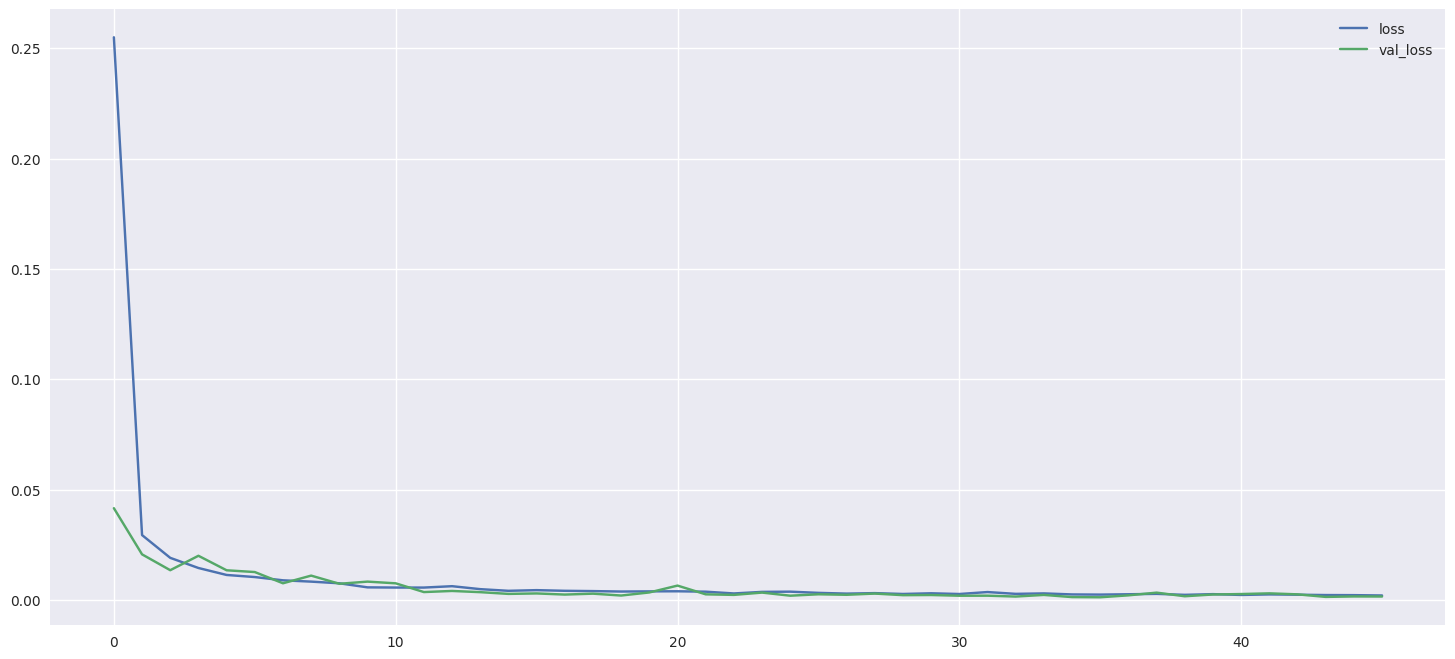

In [53]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
(history_df.loc[:, ["loss","val_loss"]]).plot()

In [210]:
# Create predictions for the close and return
Predictions = Forex_Regressor.predict(X_train_50)
print(Predictions.shape)

998/998 [==============================] - 5s 5ms/step
(31936, 2)


(array([   66.,   224.,   869.,  3375., 11675., 11229.,  3350.,   840.,
          272.,    60.]),
 array([-4.56557717e+00, -3.65171217e+00, -2.73784718e+00, -1.82398219e+00,
        -9.10117194e-01,  3.74779926e-03,  9.17612792e-01,  1.83147779e+00,
         2.74534278e+00,  3.65920777e+00,  4.57307276e+00]),
 <BarContainer object of 10 artists>)

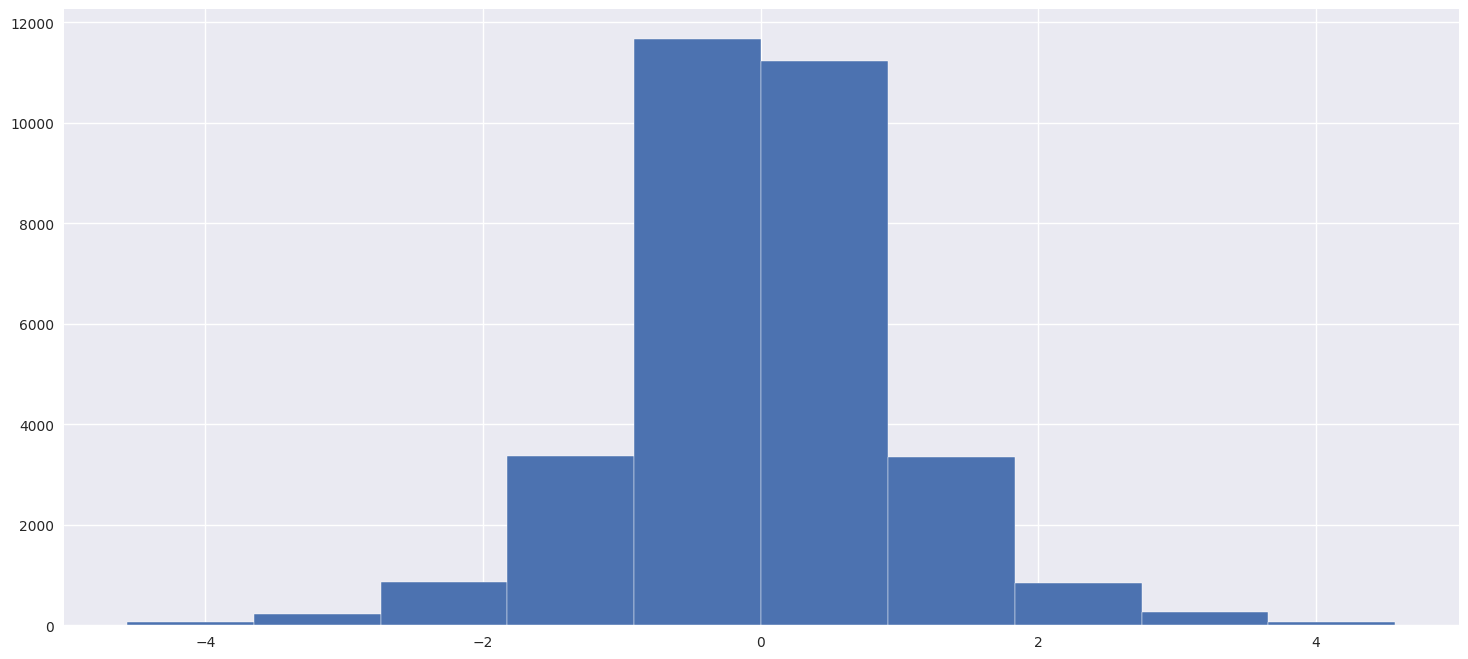

In [55]:
# Review the distribution of normalised returns
plt.hist(y_train["returns"])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



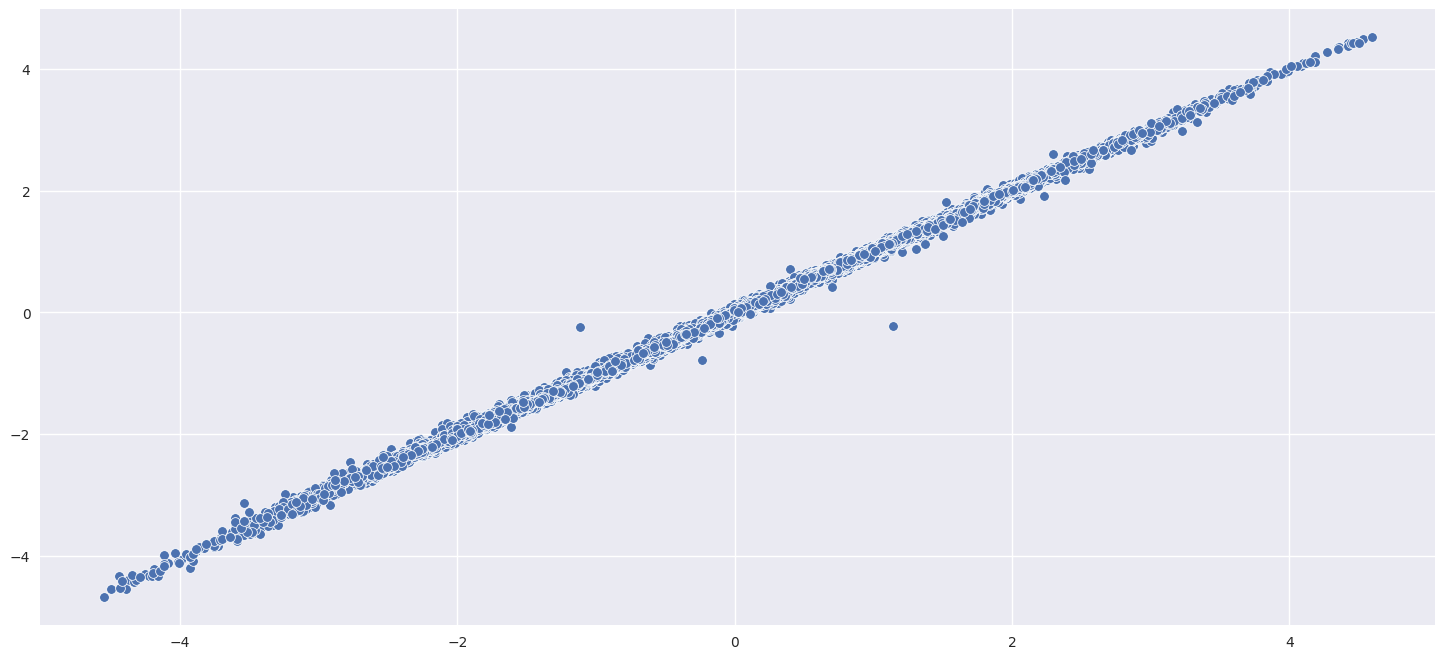

In [56]:
# Plot the truth vs predicted to evaluate the predictions of the close
Figure = plt.Figure()
sns.scatterplot(x = y_train_50[:,0], y = Predictions[:,0])
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



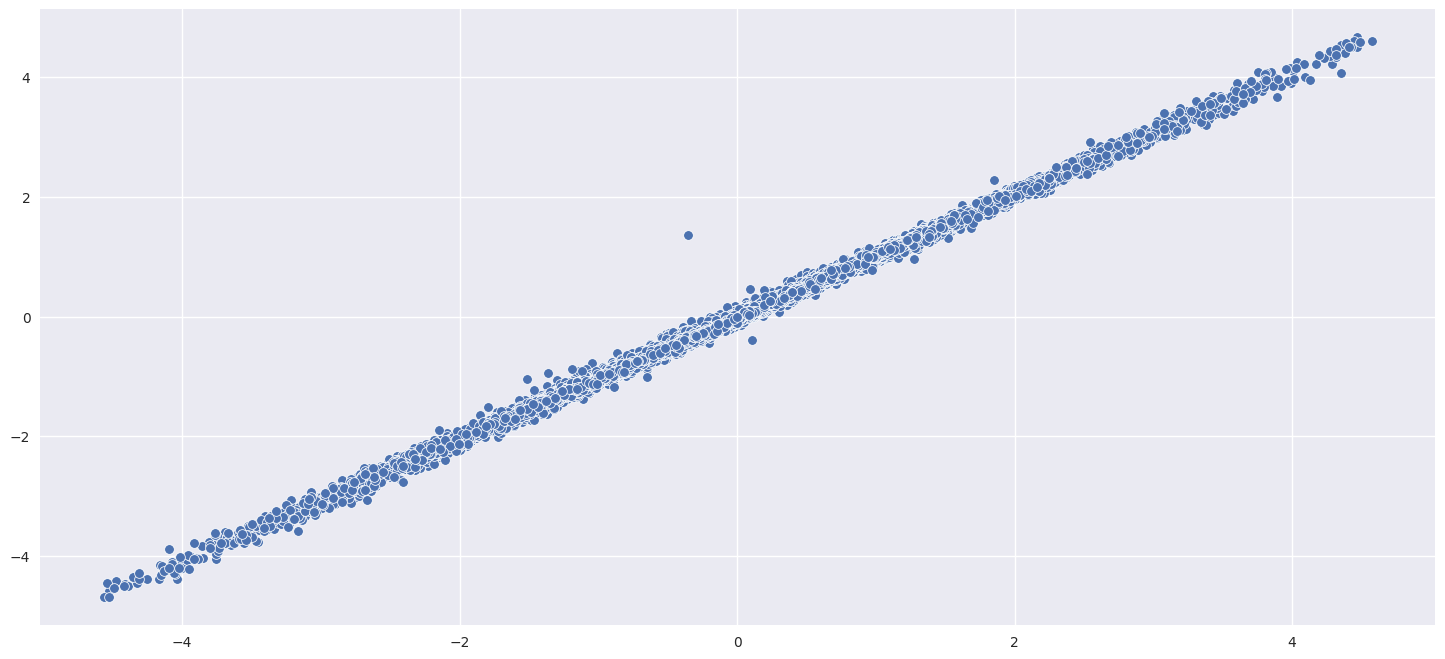

In [58]:
# Plot the truth vs predicted to evaluate the predictions of the returns
Figure = plt.Figure()
sns.scatterplot(x = y_train_50[:,1], y = Predictions[:,1])
plt.show()

In [59]:
# Used as reference for later
unaltered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32960 entries, 33234 to 224
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   unaltered_open           32960 non-null  float64
 1   unaltered_close          32960 non-null  float64
 2   unaltered_low            32960 non-null  float64
 3   unaltered_high           32960 non-null  float64
 4   unaltered_returns        32960 non-null  float64
 5   unaltered_sLow           32960 non-null  float64
 6   unaltered_sHigh          32960 non-null  float64
 7   unaltered_returns_means  32960 non-null  float64
 8   unaltered_returns_stds   32960 non-null  float64
 9   unaltered_close_means    32960 non-null  float64
 10  unaltered_close_stds     32960 non-null  float64
dtypes: float64(11)
memory usage: 3.0 MB


In [60]:
unaltered.iloc[24:-1000].shape

(31936, 11)

In [211]:
# Transform the normalised returns into unormalised returns
Predicted_Returns = (Predictions[:,1] * unaltered.shift(1).iloc[24:-1000, 8].reset_index(drop = True)) + unaltered.shift(1).iloc[24:-1000, 7].reset_index(drop = True)

In [212]:
# Create the baseline returns predicted by the moving average
Bias_Returns = (1.0 * unaltered.shift(1).iloc[24:-1000, 8].reset_index(drop = True)) + unaltered.shift(1).iloc[24:-1000, 7].reset_index(drop = True)

In [213]:
# Create the baseline close predicted by the moving average
Bias_Predictions = (1.0 * unaltered.shift(1).iloc[24:-1000,10].reset_index(drop = True)) + unaltered.shift(1).iloc[24:-1000,9].reset_index(drop = True)

In [214]:
# Transform the normalised closes into unormalised closes
Predicted_Close = (Predictions[:,0] * unaltered.shift(1).iloc[24:-1000,10].reset_index(drop = True)) + unaltered.shift(1).iloc[24:-1000,9].reset_index(drop = True)

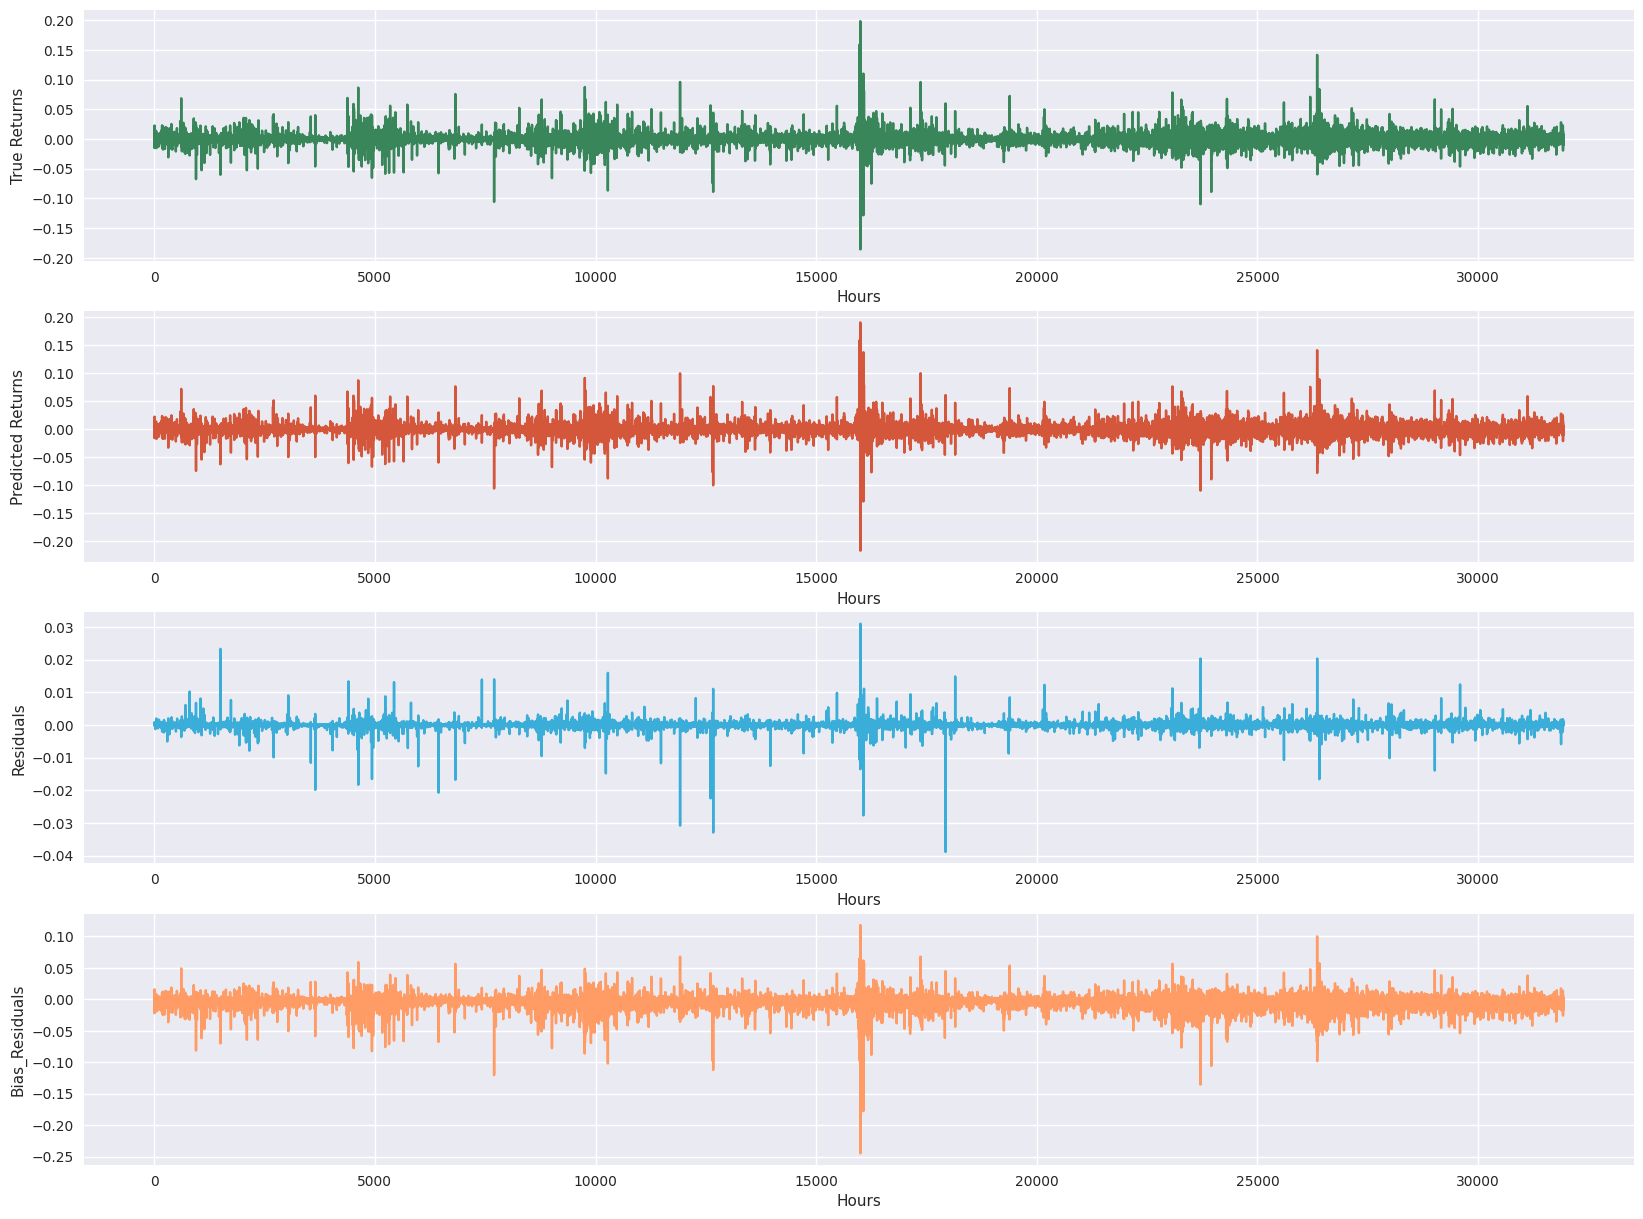

In [215]:
# Display and compare the true returns, predicted returns, baseline returns and residuals
Figure, axes = plt.subplots(4,1, figsize = (20,15))
axes[0].plot(unaltered.iloc[24:-1000, 4].reset_index(drop = True), color = "#388659")
axes[0].set_xlabel("Hours")
axes[0].set_ylabel("True Returns")
axes[1].plot(Predicted_Returns, color = "#D5573B")
axes[1].set_xlabel("Hours")
axes[1].set_ylabel("Predicted Returns")
axes[2].plot(unaltered.iloc[24:-1000, 4].reset_index(drop = True) - Predicted_Returns, color = "#3AAED8")
axes[2].set_xlabel("Hours")
axes[2].set_ylabel("Residuals")
axes[3].plot(unaltered.iloc[24:-1000, 4].reset_index(drop = True) - Bias_Returns, color = "#FF9B64")
axes[3].set_xlabel("Hours")
axes[3].set_ylabel("Bias_Residuals")
plt.show()

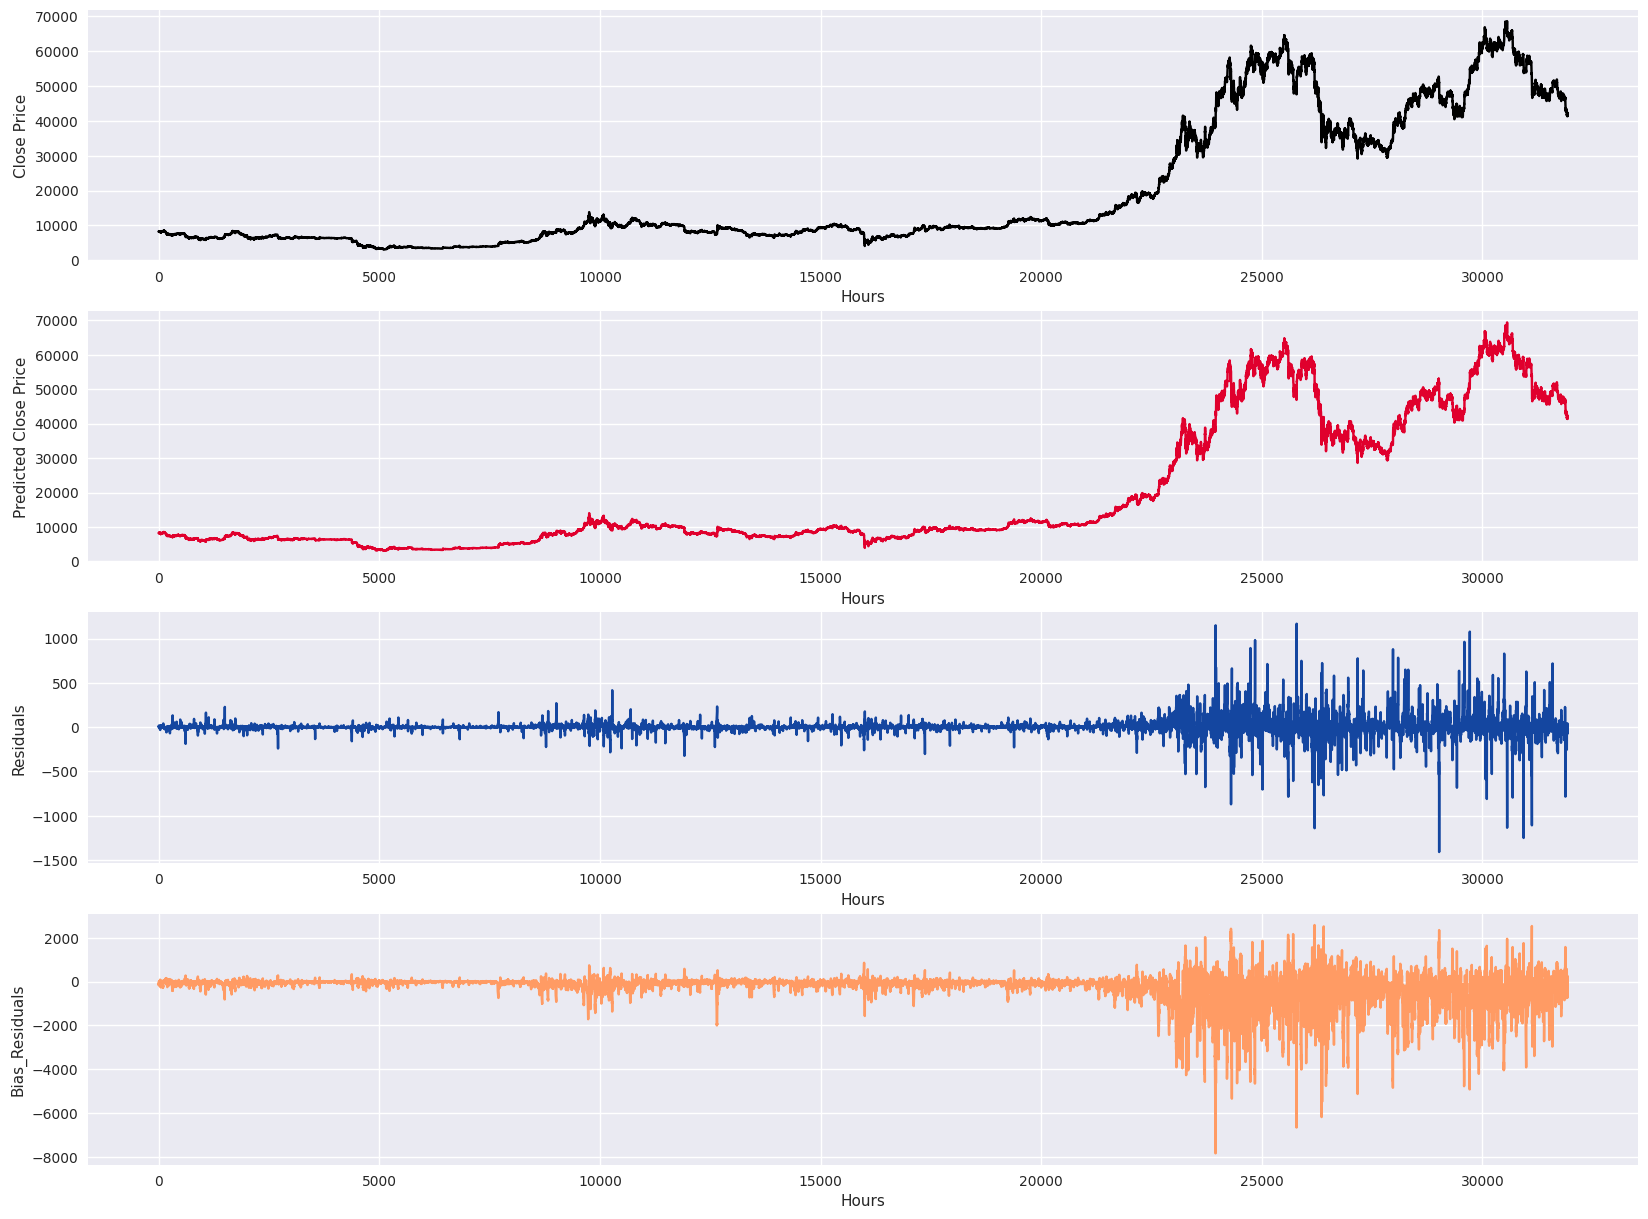

In [216]:
# Display and compare the true close, predicted close, baseline close and residuals
Figure, axes = plt.subplots(4,1, figsize = (20,15))
axes[0].plot(unaltered.iloc[24:-1000, 1].reset_index(drop = True), color = "#000000")
axes[0].set_xlabel("Hours")
axes[0].set_ylabel("Close Price")
axes[1].plot(Predicted_Close, color = "#E0002D")
axes[1].set_xlabel("Hours")
axes[1].set_ylabel("Predicted Close Price")
axes[2].plot(unaltered.iloc[24:-1000, 1].reset_index(drop = True) - Predicted_Close, color = "#1446A0")
axes[2].set_xlabel("Hours") 
axes[2].set_ylabel("Residuals")
axes[3].plot(unaltered.iloc[24:-1000, 1].reset_index(drop = True) - Bias_Predictions, color = "#FF9B64")
axes[3].set_xlabel("Hours") 
axes[3].set_ylabel("Bias_Residuals")
plt.show()

In [95]:
# Generate the Portfolio Returns for LSTM model
Portfolio_Train = pd.DataFrame()
Portfolio_Train["Returns"] = np.sign(Predicted_Returns) * unaltered.iloc[24:-1000, 4].reset_index(drop = True)
Portfolio_Train["Low"] = np.where(Portfolio_Train["Returns"] < 0, unaltered.iloc[24:-1000,5].reset_index(drop = True), -unaltered.iloc[24:-1000,6])
Portfolio_Train["High"] = np.where(Portfolio_Train["Returns"] >0, unaltered.iloc[24:-1000, 6].reset_index(drop = True), -unaltered.iloc[24:-1000,5])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Text(0, 0.5, 'Returns')

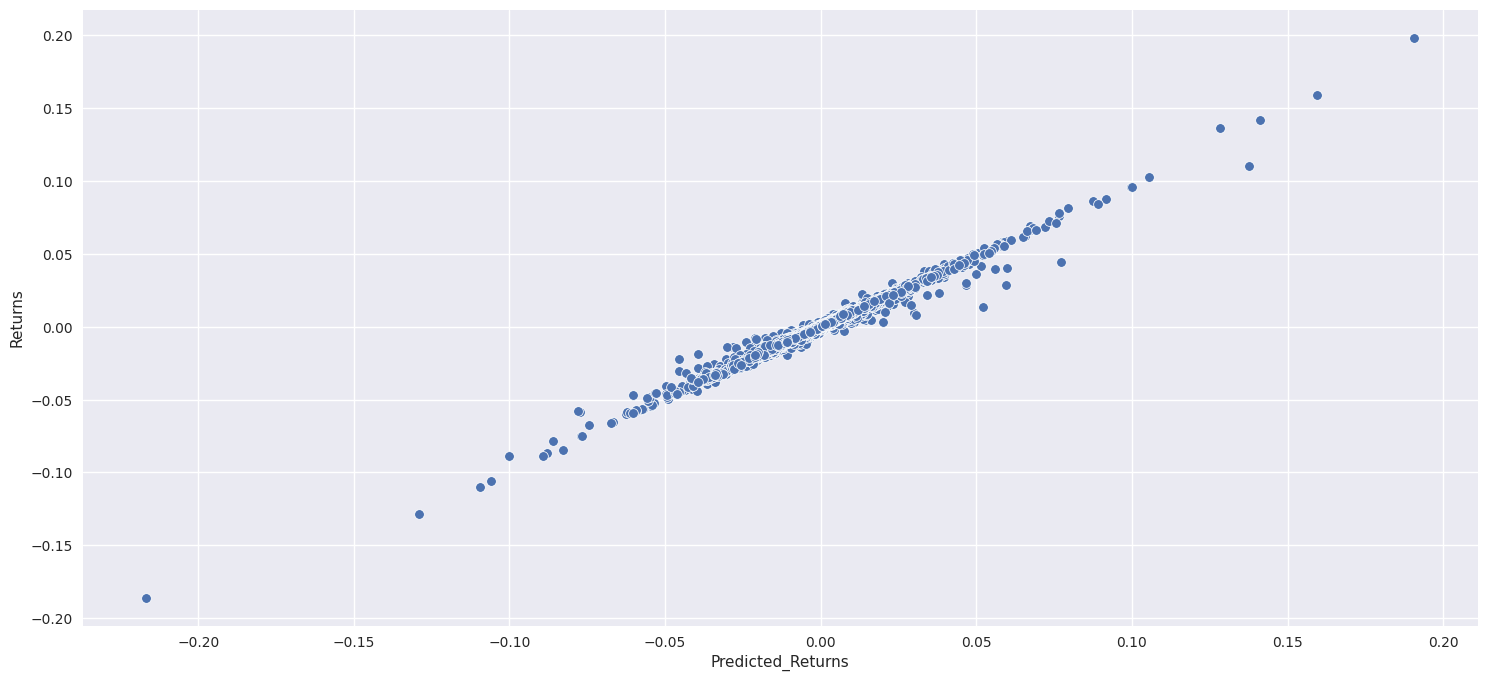

In [103]:
# Plot the cumulative sum of the returns
sns.scatterplot(x = Predicted_Returns, y = unaltered.iloc[24:-1000, 4].reset_index(drop = True))
plt.xlabel("Predicted_Returns")
plt.ylabel("Returns")

In [65]:
# Using the Predictions from LSTM
Portfolio_Train["Returns"].describe()

count    31936.000000
mean         0.004740
std          0.006686
min         -0.003067
25%          0.001196
50%          0.002783
75%          0.005792
max          0.198299
Name: Returns, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



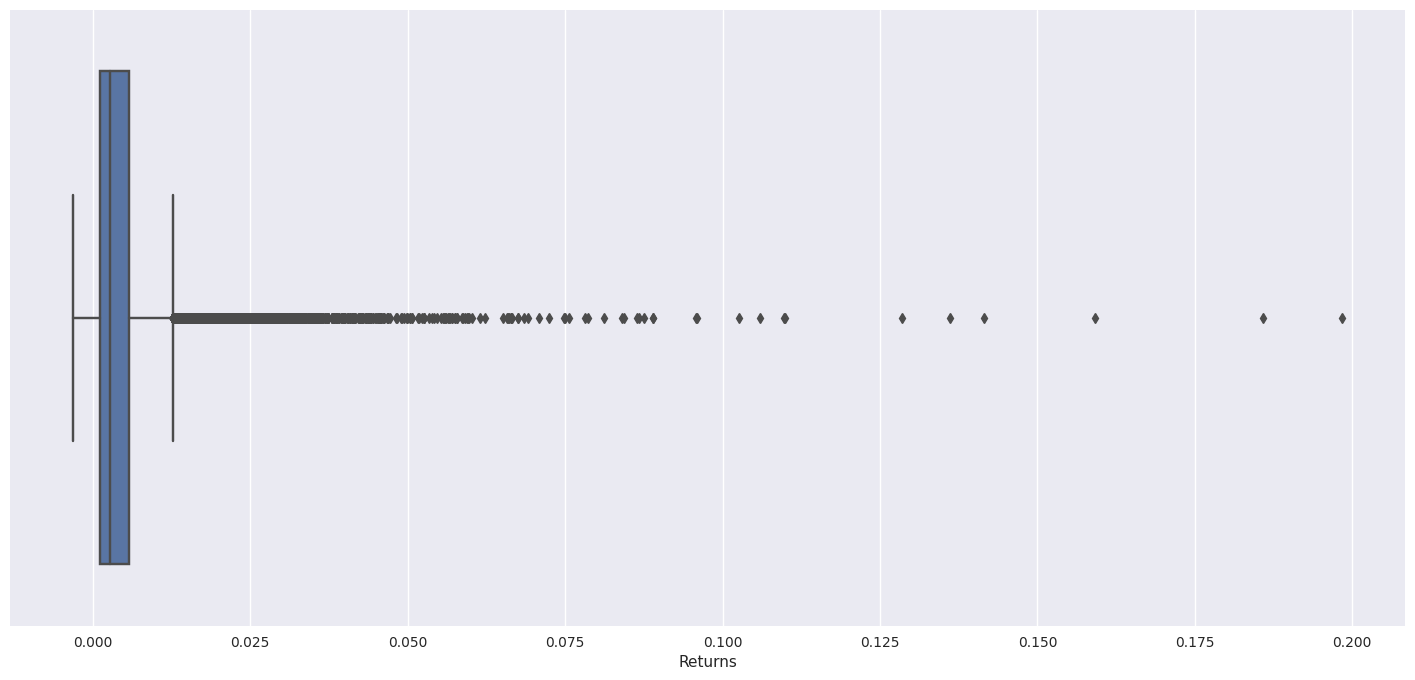

In [66]:
# Using the Predictions from the LSTM:
sns.boxplot(data = Portfolio_Train, x = "Returns")
plt.show()

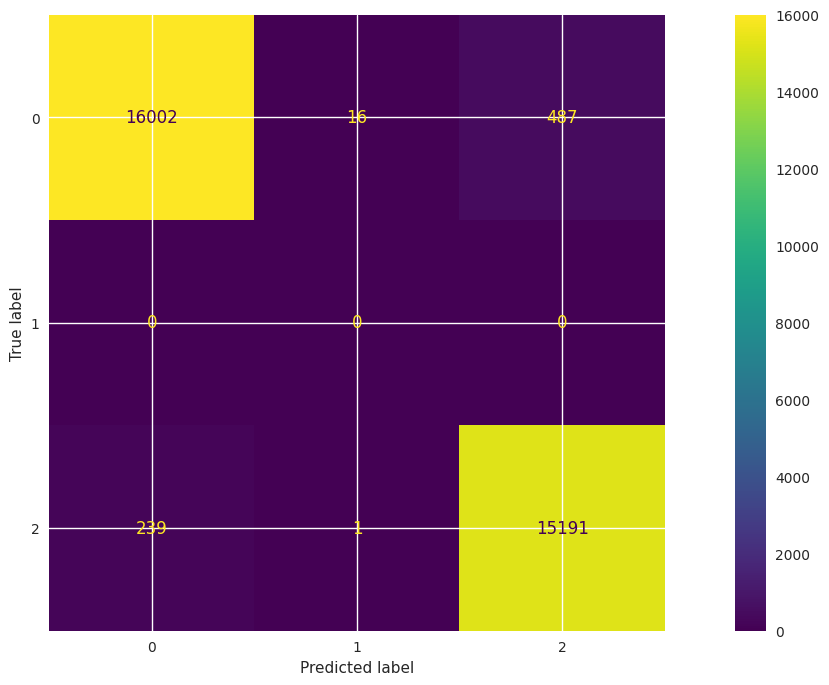

In [67]:
#Compute the confusion matrix for the LSTM Predictions model's 
#predictions
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_mat = confusion_matrix((np.sign(Predicted_Returns)).values,np.sign(unaltered.iloc[24:-1000, 4].reset_index(drop = True)).values)
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

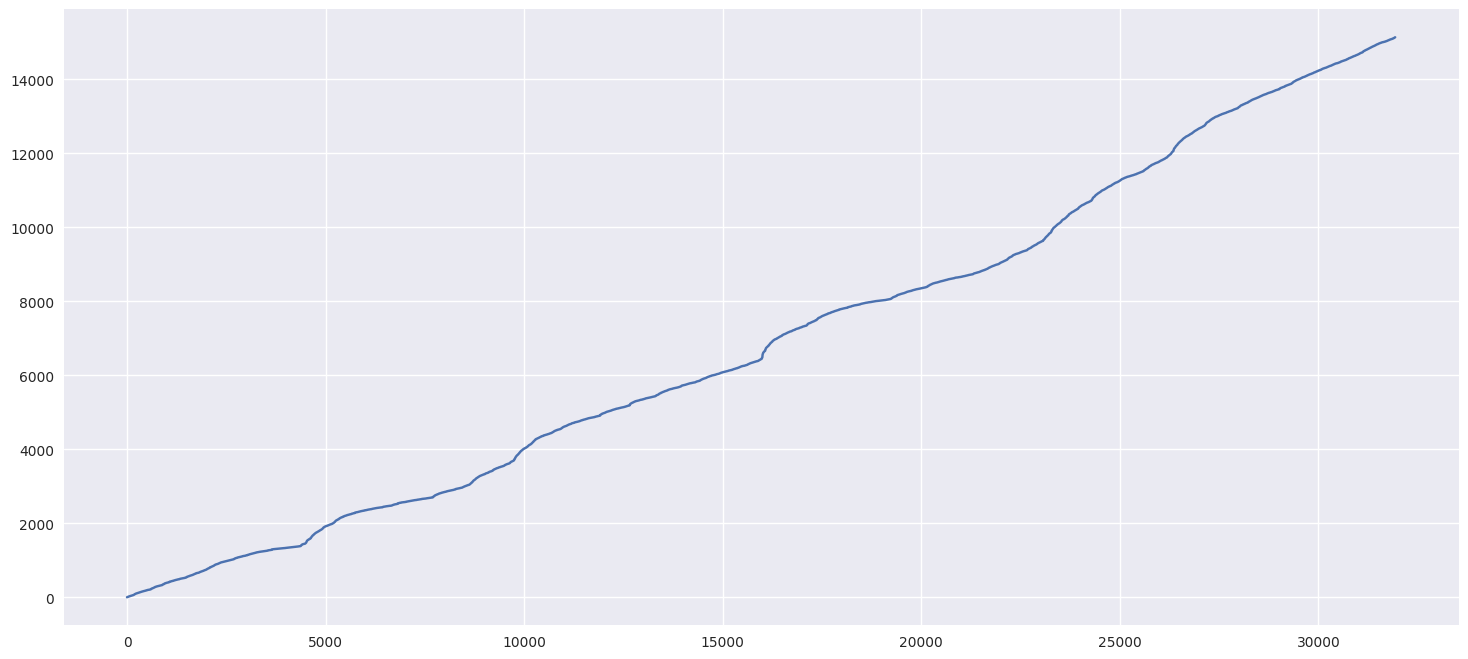

In [209]:
# The cumulative returns of this portfolio strategy
plt.plot(Portfolio_Train["Returns"].cumsum()*100)

In [69]:
# Find the best take profit given the sharpe ratio
def find_best_tp(tp):
    tp = tp/100
    
    # Create the portfolio
    pf = Portfolio_Train.copy()
    pf.columns = ["low", "Return", "high"]

    # Apply the tp
    pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
    down = pf["Return"].values
    down = down[down<0]
    
    # Return sharpe raatio
    return np.sqrt(252)*pf["Return"].mean()/down.std()

pd.DataFrame([find_best_tp(tp) for tp in np.linspace(0.5,10,30)],  index=np.linspace(0.5,10,30), columns=["Sharpe"]).sort_values(by = "Sharpe", ascending = False)

Sharpe
0.500000   17.351008
0.827586    4.247753
1.155172   -2.188657
1.482759   -5.204796
1.810345   -6.943849
2.137931   -7.873376
2.465517   -8.532836
2.793103   -8.873892
10.000000  -8.910961
9.672414   -8.940304
9.344828   -8.959346
9.017241   -8.970716
8.689655   -9.022072
8.362069   -9.044925
8.034483   -9.065693
7.706897   -9.089275
7.379310   -9.126771
3.120690   -9.133023
7.051724   -9.164448
6.724138   -9.202681
6.396552   -9.240550
3.448276   -9.255132
6.068966   -9.274430
5.741379   -9.308600
3.775862   -9.340019
5.413793   -9.342165
5.086207   -9.371357
4.103448   -9.388597
4.758621   -9.390166
4.431034   -9.403195

In [70]:
# Find the best sell loss given the sharpe ratio
def find_best_sl(sl):
    sl = sl/100
    
    # Create the portfolio
    pf = Portfolio_Train.copy()
    pf.columns = ["low", "Return", "high"]

    # Apply the tp
    pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)
    
    # Return sharpe raatio
    return np.sqrt(252)*pf["Return"].mean()/pf["Return"].std()
pd.DataFrame([find_best_sl(sl) for sl in np.linspace(1,10,30)],  index=np.linspace(1,10,30), columns=["Sharpe"]).sort_values(by = "Sharpe", ascending = False)

Sharpe
10.000000 -7.990780
9.689655  -8.003023
9.379310  -8.015664
9.068966  -8.028749
8.758621  -8.042968
8.448276  -8.059801
8.137931  -8.077187
7.827586  -8.095452
7.517241  -8.115003
7.206897  -8.137002
6.896552  -8.161753
6.586207  -8.189414
6.275862  -8.220199
5.965517  -8.253035
5.655172  -8.288948
5.344828  -8.328491
5.034483  -8.371636
4.724138  -8.419752
4.413793  -8.473273
4.103448  -8.532192
3.793103  -8.600117
3.482759  -8.677181
3.172414  -8.761830
1.000000  -8.801643
2.862069  -8.854337
2.551724  -8.952008
2.241379  -9.048918
1.310345  -9.116875
1.931034  -9.133612
1.620690  -9.177054

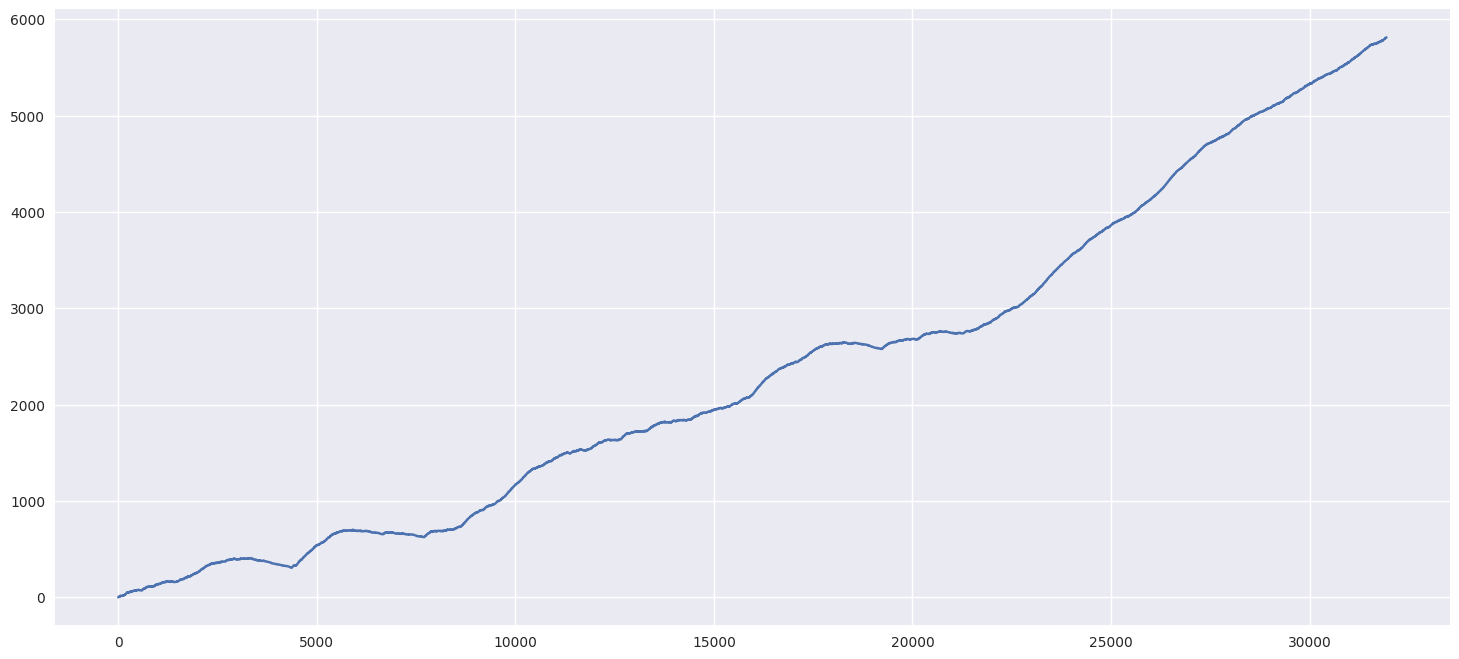

In [71]:
# The optimal, leverage, take profit and sell loss
leverage = 1.0
tp = 0.50/100
sl = 5.00/100
pf = Portfolio_Train.copy()*leverage
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)

plt.plot(pf["Return"].cumsum()*120)

In [190]:
# Predict the closes and returns for the unseen data
Predictions = Forex_Regressor.predict(X_test_50)
print(Predictions.shape)

31/31 [==============================] - 0s 5ms/step
(976, 2)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



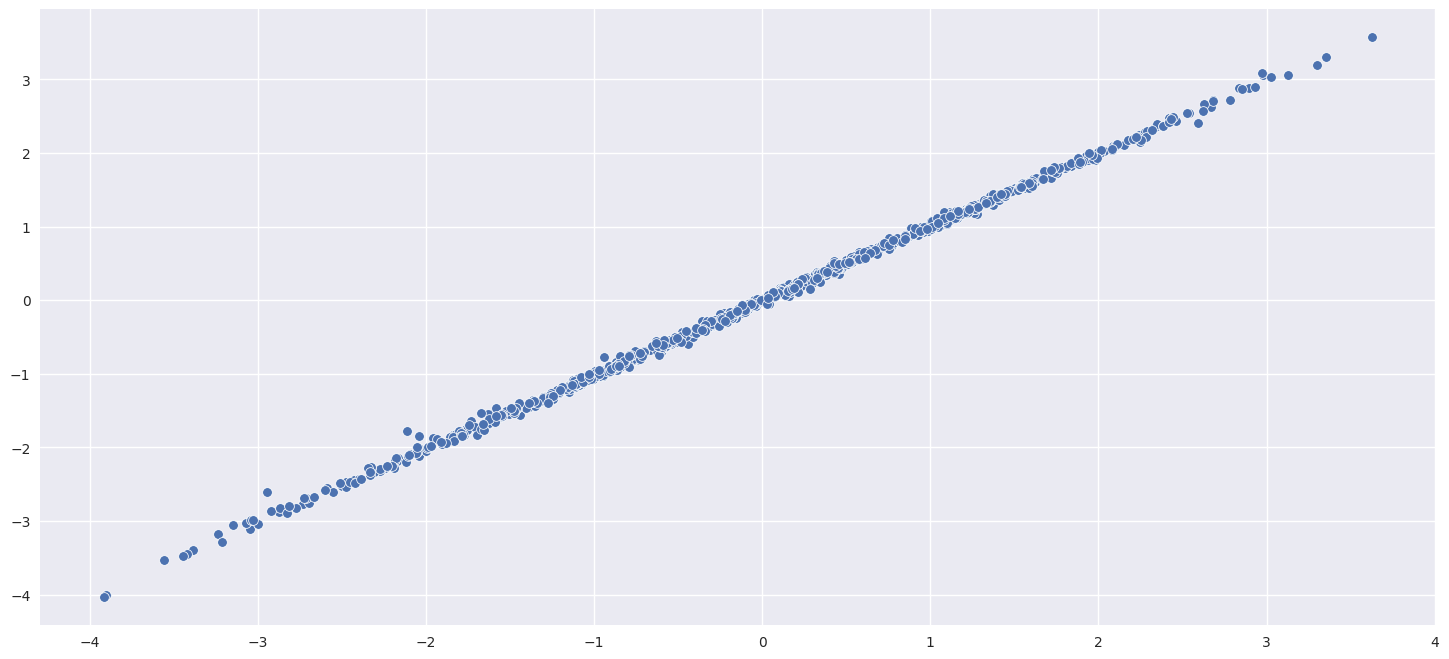

In [73]:
# Plot the truth vs predicted for the closes
Figure = plt.Figure()
sns.scatterplot(x = y_test_50[:,0], y = Predictions[:,0])
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



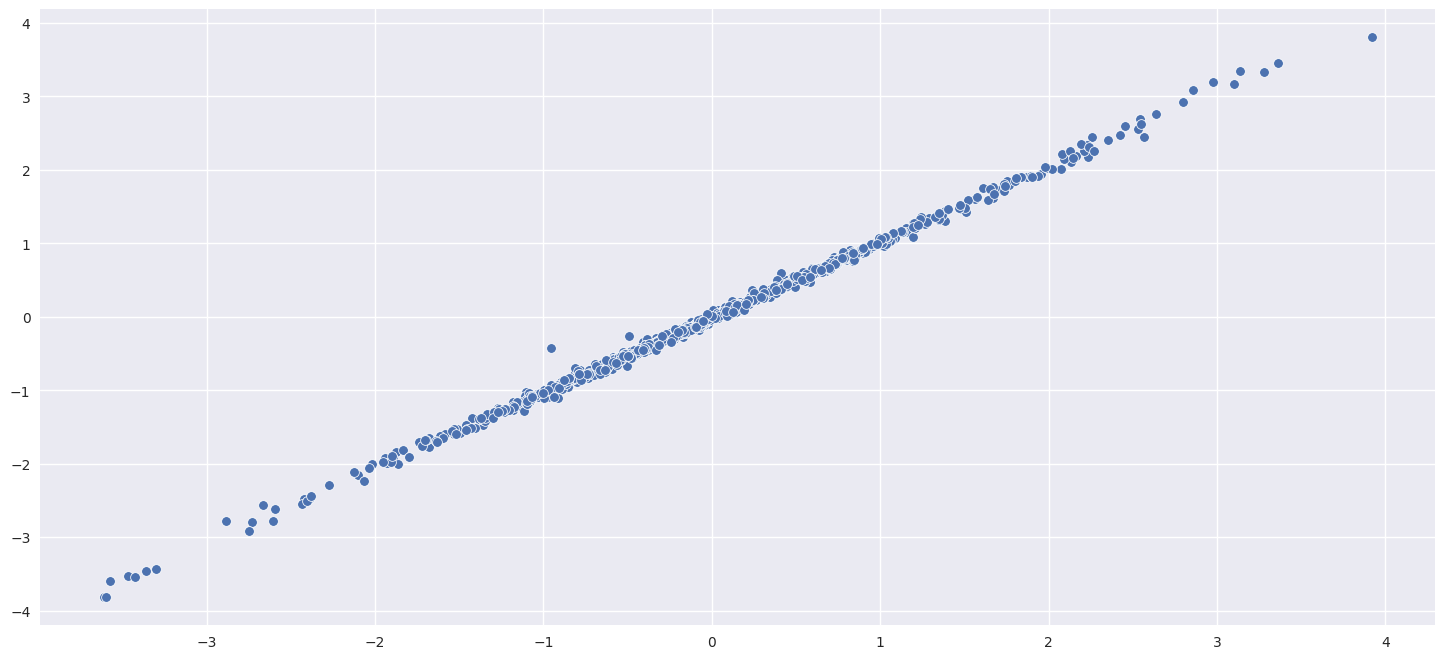

In [74]:
# Plot the true vs predicted for the returns
Figure = plt.Figure()
sns.scatterplot(x = y_test_50[:,1], y = Predictions[:,1])
plt.show()

In [199]:
# Transform the normalised returns into unormalised returns
Predicted_Returns = (Predictions[:,1] * unaltered.shift(1).iloc[-976:, 8].reset_index(drop = True)) + unaltered.shift(1).iloc[-976:, 7].reset_index(drop = True)

In [200]:
# Create the baseline returns predicted by the moving average
Bias_Returns = (1.0 * unaltered.shift(1).iloc[-976:, 8].reset_index(drop = True)) + unaltered.shift(1).iloc[-976:, 7].reset_index(drop = True)

In [201]:
# Transform the normalised closes into unormalised closes
Predicted_Close = (Predictions[:,0] * unaltered.shift(1).iloc[-976:,10].reset_index(drop = True)) + unaltered.shift(1).iloc[-976:,9].reset_index(drop = True)

In [202]:
# Create the baseline close predicted by the moving average
Bias_Predictions = (1.0 * unaltered.shift(1).iloc[-976:,10].reset_index(drop = True)) + unaltered.shift(1).iloc[-976:,9].reset_index(drop = True)

In [147]:
# Creates the returns for the Portfolio
Portfolio_Valid = pd.DataFrame()
Portfolio_Valid["Returns"] = np.sign(Predicted_Returns) * unaltered.iloc[-976:, 4].reset_index(drop = True)
Portfolio_Valid["Low"] = np.where(Portfolio_Valid["Returns"] < 0, unaltered.iloc[-976:,5].reset_index(drop = True), -unaltered.iloc[-976:,6])
Portfolio_Valid["High"] = np.where(Portfolio_Valid["Returns"] > 0, unaltered.iloc[-976:, 6].reset_index(drop = True), -unaltered.iloc[-976:,5])

In [148]:
Portfolio_Valid.describe()

Returns         Low        High
count  976.000000  976.000000  976.000000
mean     0.004973   -0.005270    0.005270
std      0.005403    0.009985    0.009985
min     -0.000784   -0.149115   -0.036295
25%      0.001566   -0.008440    0.000305
50%      0.003372   -0.004021    0.004021
75%      0.006121   -0.000305    0.008440
max      0.047384    0.036295    0.149115

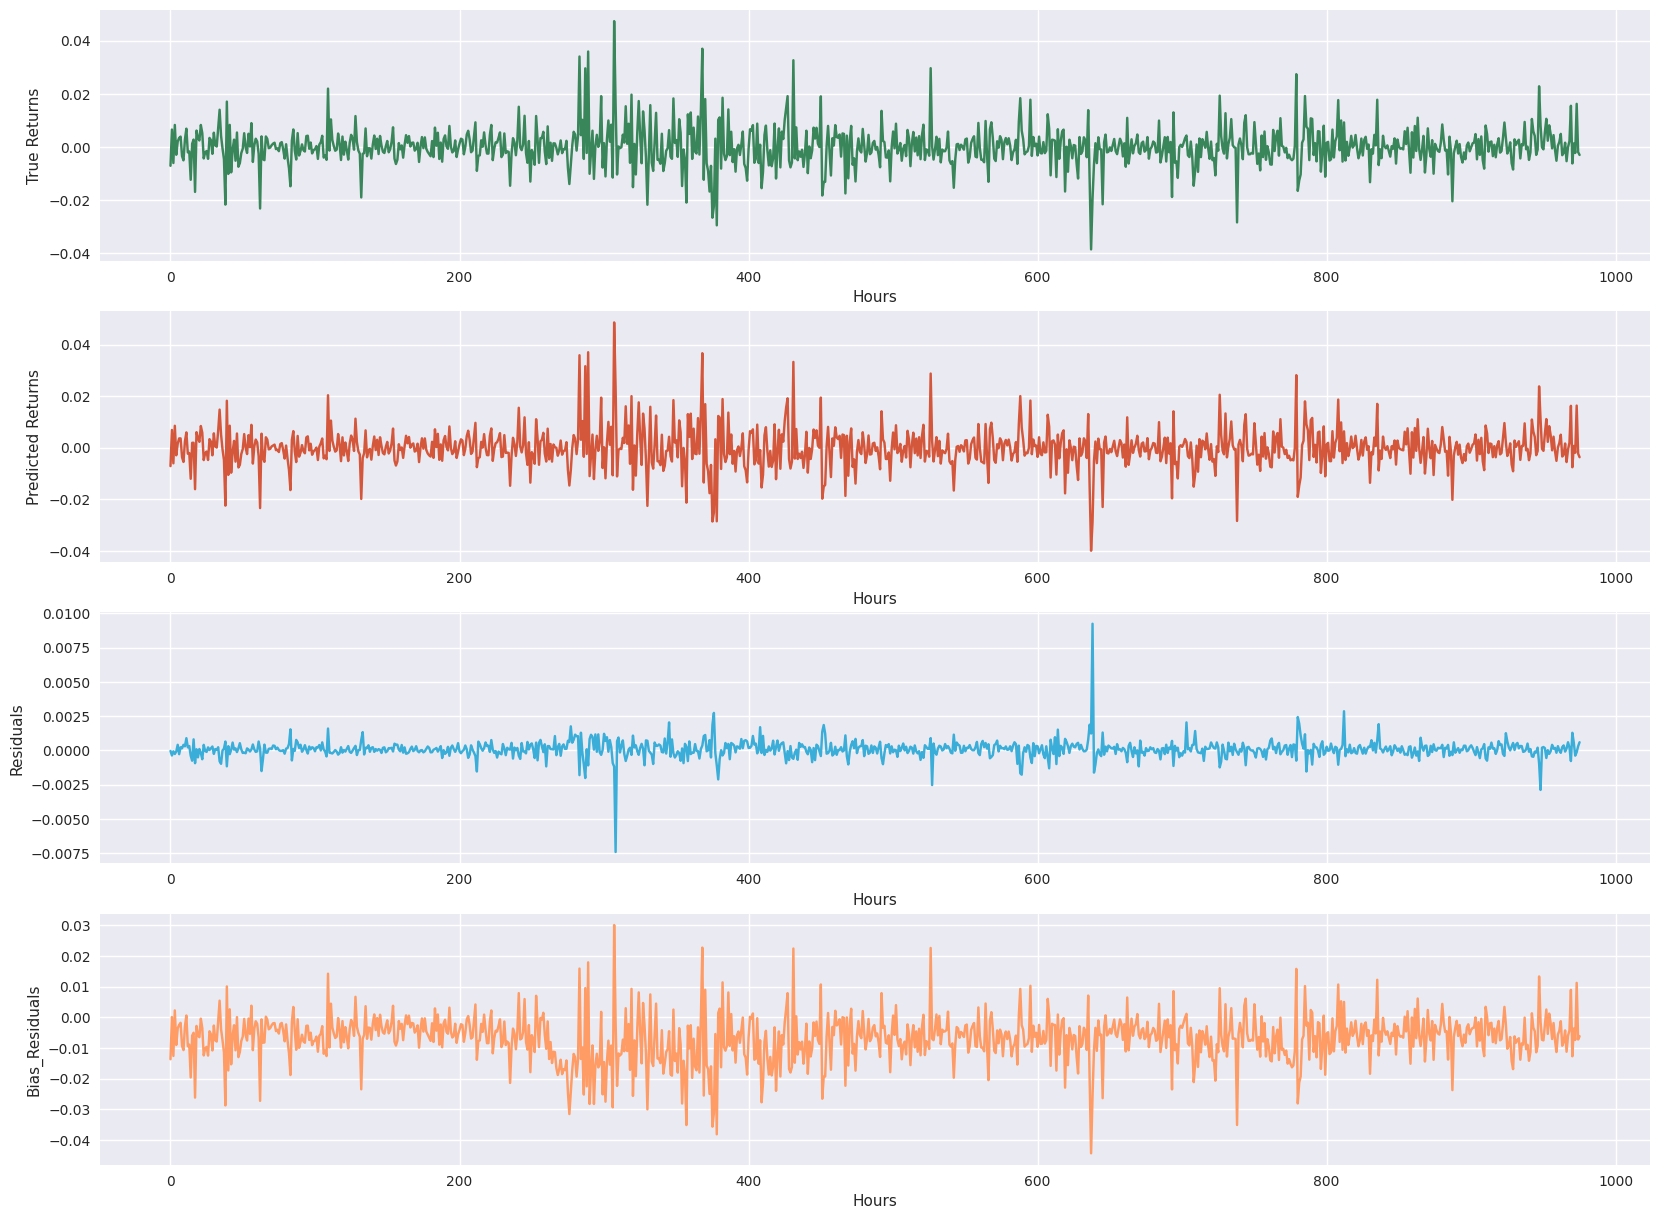

In [203]:
#Plots and compares the true returns, predicted returns and bias returns
Figure, axes = plt.subplots(4,1, figsize = (20,15))
axes[0].plot(unaltered.iloc[-976:, 4].reset_index(drop = True), color = "#388659")
axes[0].set_xlabel("Hours")
axes[0].set_ylabel("True Returns")
axes[1].plot(Predicted_Returns, color = "#D5573B")
axes[1].set_xlabel("Hours")
axes[1].set_ylabel("Predicted Returns")
axes[2].plot(unaltered.iloc[-976:, 4].reset_index(drop = True) - Predicted_Returns, color = "#3AAED8")
axes[2].set_xlabel("Hours")
axes[2].set_ylabel("Residuals")
axes[3].plot(unaltered.iloc[-976:, 4].reset_index(drop = True) - Bias_Returns, color = "#FF9B64")
axes[3].set_xlabel("Hours")
axes[3].set_ylabel("Bias_Residuals")
plt.show()

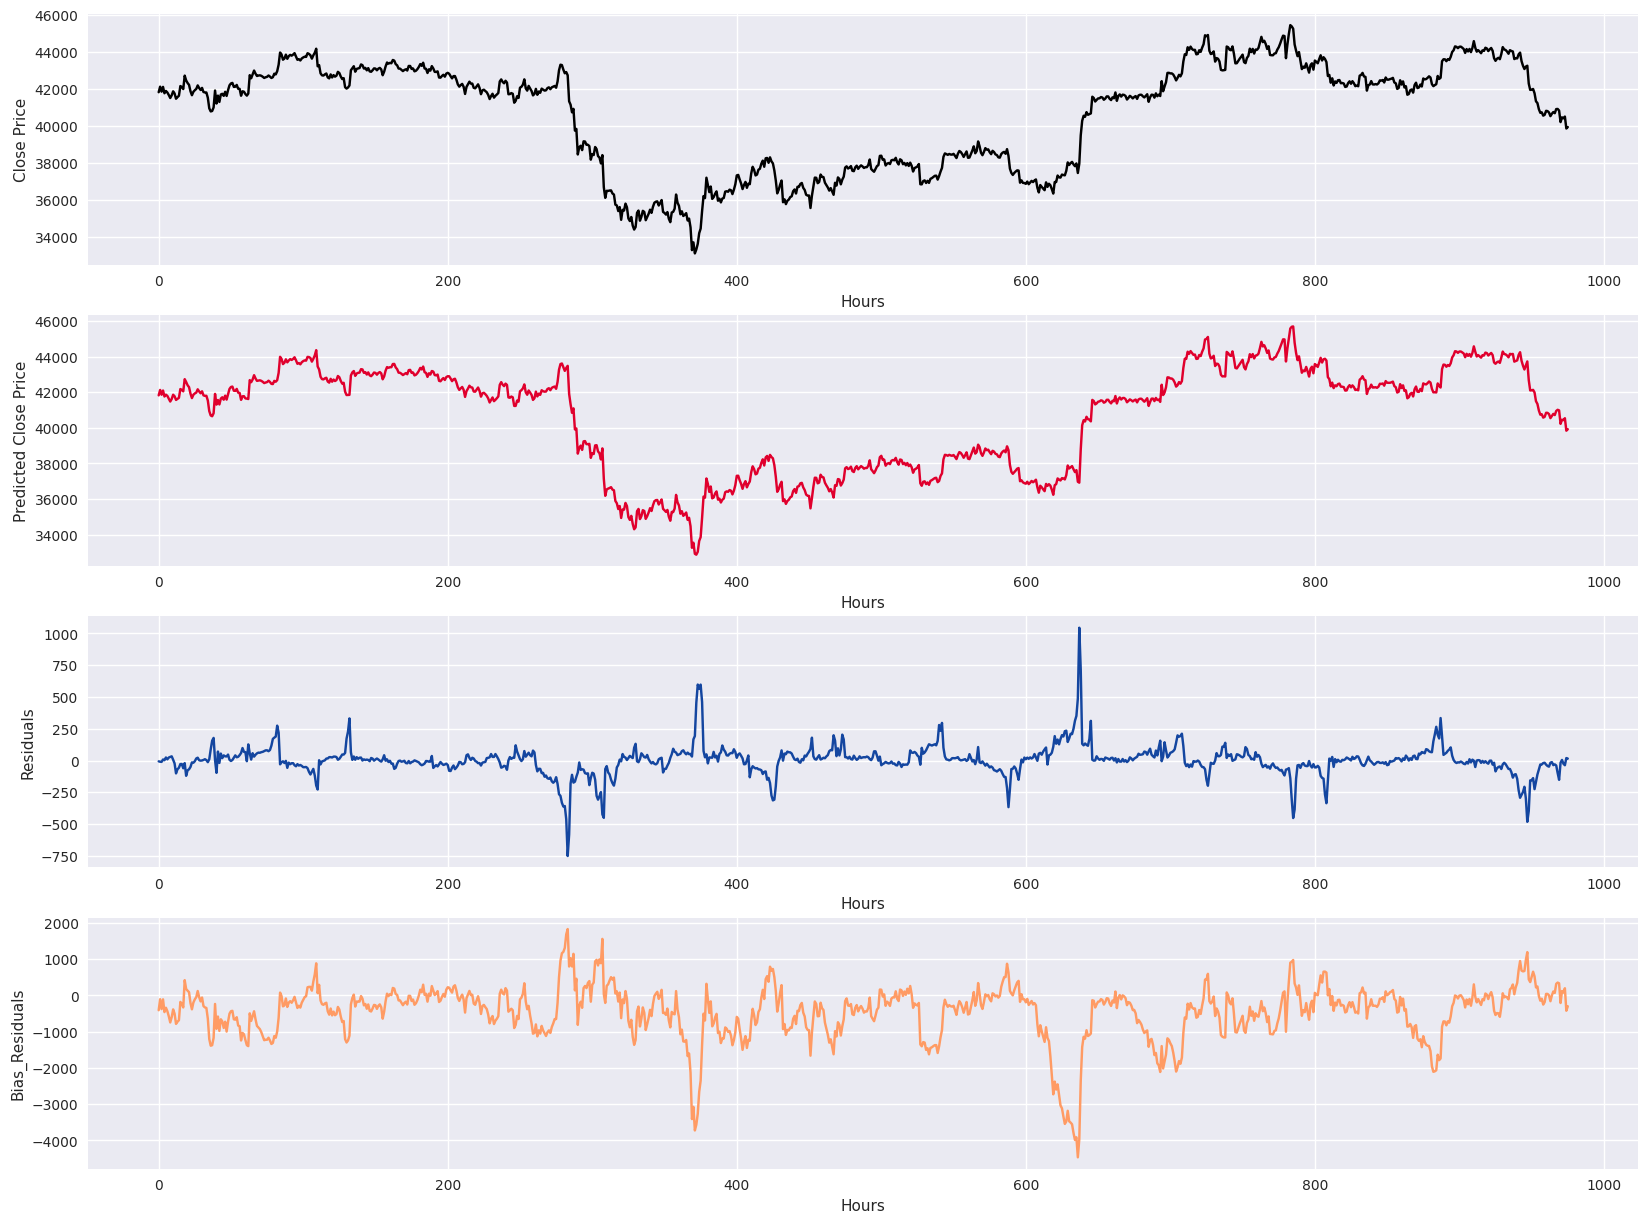

In [204]:
#Plots and compares the true close, predicted close and bias close
Figure, axes = plt.subplots(4,1, figsize = (20,15))
axes[0].plot(unaltered.iloc[-976:, 1].reset_index(drop = True), color = "#000000")
axes[0].set_xlabel("Hours")
axes[0].set_ylabel("Close Price")
axes[1].plot(Predicted_Close, color = "#E0002D")
axes[1].set_xlabel("Hours")
axes[1].set_ylabel("Predicted Close Price")
axes[2].plot(unaltered.iloc[-976:, 1].reset_index(drop = True) - Predicted_Close, color = "#1446A0")
axes[2].set_xlabel("Hours") 
axes[2].set_ylabel("Residuals")
axes[3].plot(unaltered.iloc[-976:, 1].reset_index(drop = True) - Bias_Predictions, color = "#FF9B64")
axes[3].set_xlabel("Hours") 
axes[3].set_ylabel("Bias_Residuals")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



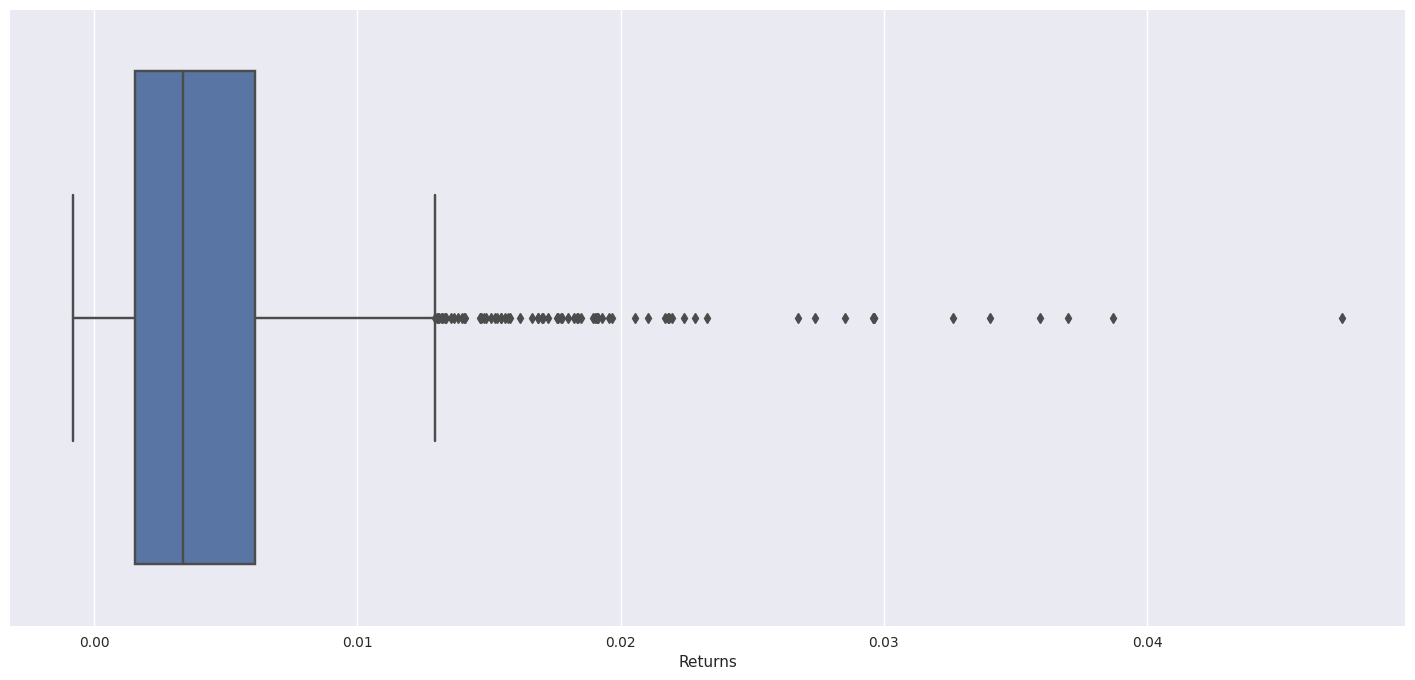

In [206]:
# Using the Predictions from the LSTM:
sns.boxplot(data = Portfolio_Valid, x = "Returns")
plt.show()

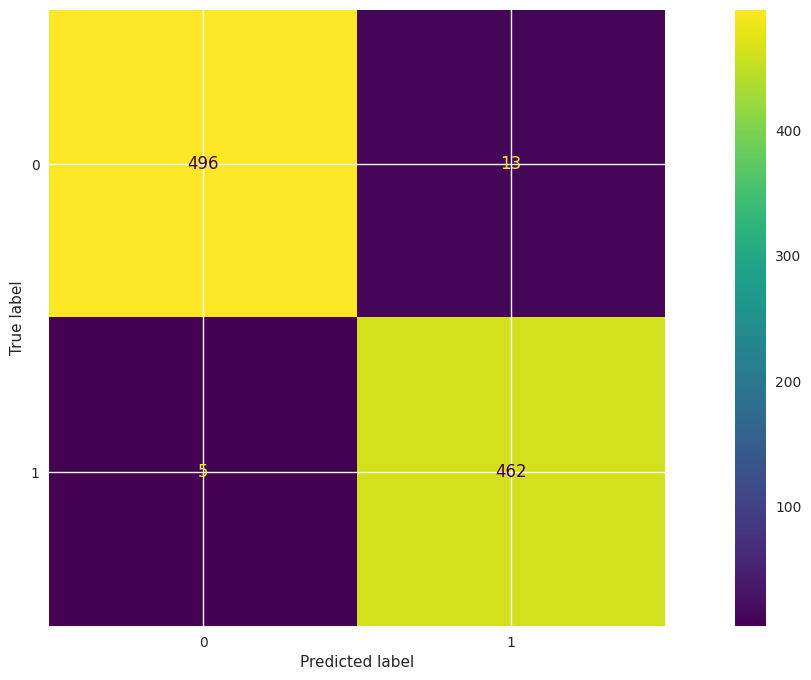

In [208]:
#Compute the confusion matrix for the LSTM Predictions model's 
#predictions
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_mat = confusion_matrix((np.sign(Predicted_Returns)).values,np.sign(unaltered.iloc[-976:, 4].reset_index(drop = True)).values)
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

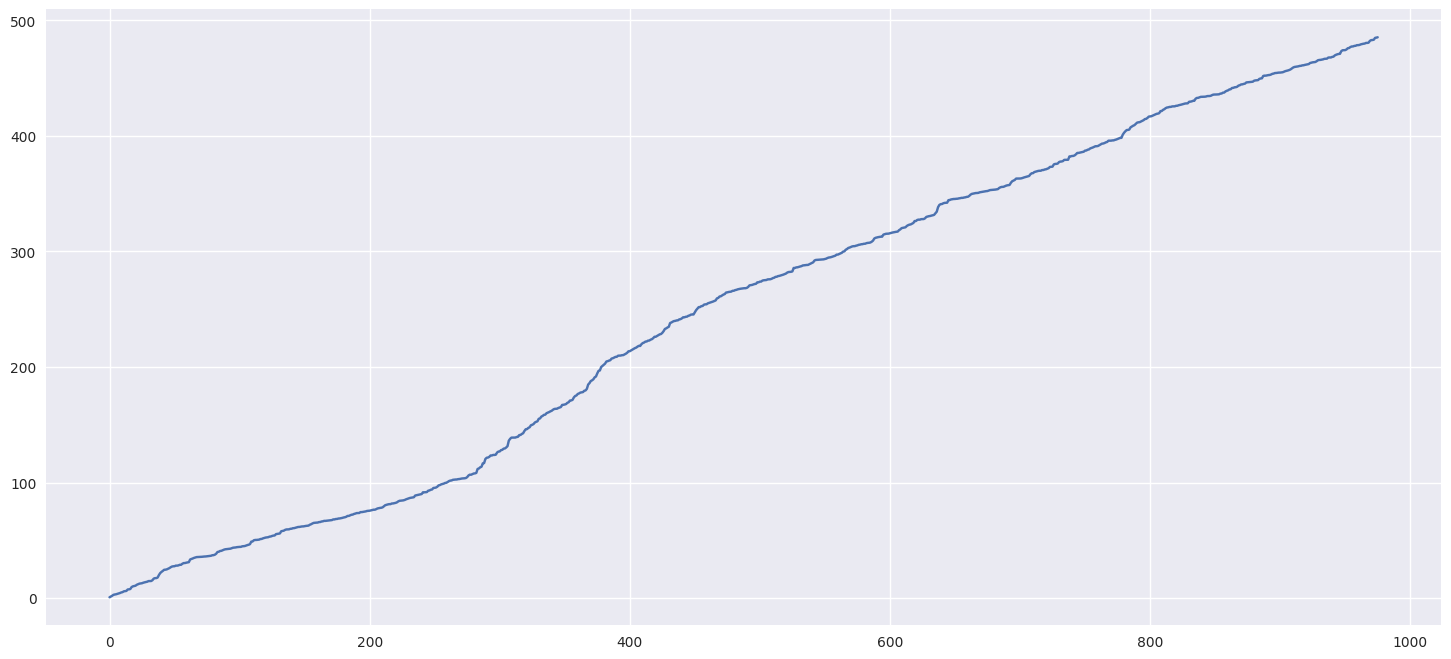

In [78]:
# Plot the cumulative sum of the returns
plt.plot(Portfolio_Valid["Returns"].cumsum()*100)